In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

In [2]:
summ = pd.read_csv('summtab.csv')

In [3]:
cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2['Part'] = 2

In [4]:
cross2 = join(cross2,full,keys='src_n')

In [5]:
allcross = vstack(cross,cross2)

In [6]:
allcross[:6]

src_n,Porb,RA_OGLE,DEC_OGLE,OII I,OII V,OIII I,OIII V,OIV I,OIV V,Part
int64,float64,str11,str11,str38,str38,str38,str38,str49,str49,int64
2,84.0,01:21:40.61,-72:57:30.9,--,--,smc_list/OGLE-III/I/smc120.1.5.dat,smc_list/OGLE-III/V/smc120.1.5.dat,smc_list/OGLE-IV/I/CALIBRATED/smc732.03.3540.dat,--,1
3,18.38,00:54:33.44,-73:41:01.3,--,--,smc_list/OGLE-III/I/smc107.5.22.dat,smc_list/OGLE-III/V/smc107.5.5.dat,smc_list/OGLE-IV/I/CALIBRATED/smc720.17.50.dat,smc_list/OGLE-IV/V/CALIBRATED/smc720.17.19.dat,1
4,82.37,00:59:12.74,-71:38:44.9,--,--,smc_list/OGLE-III/I/smc109.2.21.dat,smc_list/OGLE-III/V/smc109.2.5.dat,smc_list/OGLE-IV/I/CALIBRATED/smc718.01.10792.dat,smc_list/OGLE-IV/V/CALIBRATED/smc718.01.21607.dat,1
5,--,00:51:38.79,-72:17:04.8,--,--,smc_list/OGLE-III/I/smc101.4.21932.dat,smc_list/OGLE-III/V/smc101.4.39141.dat,smc_list/OGLE-IV/I/CALIBRATED/smc719.21.22049.dat,smc_list/OGLE-IV/V/CALIBRATED/smc719.21.39743.dat,1
6,17.2,00:57:02.19,-72:25:55.4,smc_list/OGLE-II/I/smc_sc7.266703.dat,smc_list/OGLE-II/V/smc_sc7.266703.dat,smc_list/OGLE-III/I/smc108.8.26225.dat,smc_list/OGLE-III/V/smc108.8.30808.dat,smc_list/OGLE-IV/I/CALIBRATED/smc719.18.378.dat,smc_list/OGLE-IV/V/CALIBRATED/smc719.18.340.dat,1
7,21.9,01:02:53.31,-72:44:35.1,smc_list/OGLE-II/I/smc_sc9.146936.dat,smc_list/OGLE-II/V/smc_sc9.146936.dat,smc_list/OGLE-III/I/smc110.6.4726.dat,smc_list/OGLE-III/V/smc110.6.8463.dat,smc_list/OGLE-IV/I/CALIBRATED/smc726.29.18.dat,smc_list/OGLE-IV/V/CALIBRATED/smc726.29.19.dat,1


# Superorbital Characterization
- sometimes there seem to be distinct categories, but better to identify features and sources can have multiple
    - still worth singling out a couple categories that really seem alike and apart from the others
- see document with by-eye categorization to help quantify features

- continue with other outlined features and optimize existing ones

# color-mag slope when bright vs. faint
- divide I range in two and fit line
- is one clearly steeper than the other?
- can also try comparing correlation coefficients


In [7]:
def div_cm(srcn,cross=allcross,interp=[],vband=[],frac=0.5,plot=False,findcorr=False):
    '''Divide color mag by middle of Iint range and fit separately.
    specify fraction of range from faintest point to include in faint piece'''
    #get LCs within function 
    if len(interp)==0:
        #check which part to determine mlist
        row = cross[cross['src_n']==srcn]
        if row['Part']==2:
            mlist = ['OII I','OIII I','OIV I']
        else: 
            mlist = ['OII I','OIII I']
        iband, vband = o.getIV(srcn,cross,stack=True,mlist=mlist,radec=False)
        interp = o.colormag(iband,vband,plot=False)
    #add interpolated I to V table
    vband['I int'] = interp
    #divide into two using interp range
    irange = np.max(interp)-np.min(interp)
    split = np.max(interp) - irange*frac
    #lower interp
    vbright = vband[vband['I int']<=split]
    vfaint = vband[vband['I int']>=split]
    #bright half linear best fit
    bmod = np.polyfit(vbright['V mag'] - vbright['I int'],vbright['I int'],1)
    blinmod = (vbright['V mag'] - vbright['I int'])*bmod[0]+bmod[1]
    #faint part
    fmod = np.polyfit(vfaint['V mag'] - vfaint['I int'],vfaint['I int'],1)
    flinmod = (vfaint['V mag'] - vfaint['I int'])*fmod[0]+fmod[1]
    
    if plot: #plot color-mag with two linear best fits
        plt.scatter(vfaint['V mag'] - vfaint['I int'],vfaint['I int'],color='black',s=4)
        plt.scatter(vbright['V mag'] - vbright['I int'],vbright['I int'],color='maroon',s=4)
        maxi,mini = np.max(interp),np.min(interp)
        plt.ylim(maxi+.01,mini-.01)
        plt.plot(vfaint['V mag'] - vfaint['I int'],flinmod)
        plt.plot(vbright['V mag'] - vbright['I int'],blinmod)
    if not findcorr:
        if np.abs(fmod[0])>np.abs(bmod[0]): print('steeper when fainter')
        elif np.abs(fmod[0])<np.abs(bmod[0]): print('steeper when brighter')
        #returns faint then bright slope
        return fmod[0],bmod[0]
    #find correlation coefficients as another check
    else:
        fcorr = np.corrcoef(vfaint['V mag']-vfaint['I int'],vfaint['I int'])[1][0]
        bcorr = np.corrcoef(vbright['V mag']-vbright['I int'],vbright['I int'])[1][0]
        return (fcorr**2,fmod[0]),(bcorr**2,bmod[0])

I and V-I correlation: -0.9784986197610509
V and V-I correlation: -0.8992727263873777


((0.5565777219184822, -0.7817142502368777),
 (0.923357633786783, -2.1097143664210405))

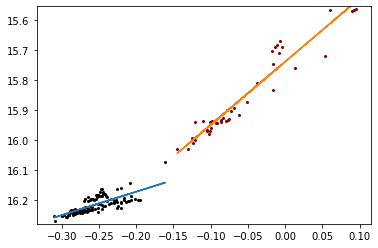

In [8]:
# comparison of correlation coefficients works well only if fraction low, etc.
div_cm(55,plot=True,frac=0.3,findcorr=True)

#### for all sources in first category; don't use $r^2$

In [9]:
#source numbers for part 1 and 2
p1n = cross['src_n']
p2n = cross2['src_n']

In [10]:
reload(o)
for s in [55,15,48,128,132]:
    if s in p1n:c = cross
    else: c = cross2
    print(div_cm(s,plot=False,frac=0.3,cross=c)) #prints slopes

I and V-I correlation: -0.9784986197610509
V and V-I correlation: -0.8992727263873777
steeper when brighter
(-0.7817142502368777, -2.1097143664210405)
I and V-I correlation: -0.9372414483256165
V and V-I correlation: -0.8515095648198383
steeper when brighter
(-1.414901384568145, -1.721822626558221)
I and V-I correlation: -0.9708981007790428
V and V-I correlation: -0.7540319474968079
steeper when brighter
(-0.5373189569373191, -2.071339432112716)
I and V-I correlation: -0.945568932143824
V and V-I correlation: -0.8840279171742701
steeper when brighter
(-1.8257551315917082, -1.9894361407400687)
I and V-I correlation: -0.9647345966389136
V and V-I correlation: -0.9002903341106792
steeper when brighter
(-0.8301604164589212, -2.1829490626005708)


In [69]:
nums = cross['src_n']

In [12]:
#now for a few sources not in the group
for s in nums[:5]: #the other ones are part 2; can do later
    print(div_cm(s,plot=False,frac=0.3))

I and V-I correlation: -0.9846799925699677
V and V-I correlation: -0.9546678612457401
steeper when brighter
(-1.8726433827108229, -2.785861846153874)
I and V-I correlation: -0.8002922261337712
V and V-I correlation: -0.6698593996852642
steeper when fainter
(-1.7351281369546334, -1.37878276183988)
I and V-I correlation: -0.883934340856408
V and V-I correlation: 0.6471296353848744
steeper when fainter
(-0.9113626805486055, -0.40648367934272983)
I and V-I correlation: -0.6677821537439047
V and V-I correlation: 0.17975703286765632
steeper when brighter
(-0.10783272462329767, -0.6362910453747979)
I and V-I correlation: -0.7854401757019701
V and V-I correlation: -0.44726007362846626
steeper when brighter
(-0.5788820480420496, -2.5619734890500827)


can be used as one needed characteristic for this category but not going to distinguish being in/out of the group

# is there a base state?
- try to make three categories: 'normal' state at brightest, at faintest, and no 'normal' state (continuous variation)

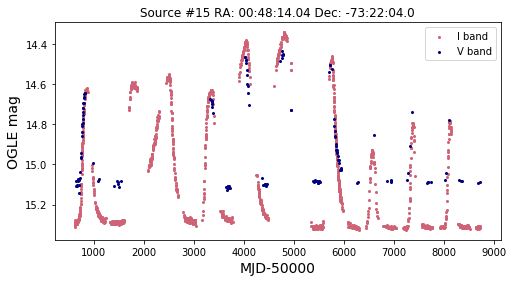

In [13]:
#how many points within some range from brightest vs. faintest point
#maybe check that they occur in every epoch?
iband,vband = o.getIV(15,cross,stack=True,plot=True)

In [14]:
len(cross2)

51

In [64]:
def findbase(srcn,cross=cross,iband=[],vband=[],plot=True,cut=100,diff=0.1,frac=False,printall=False,perc=0,checkog=True):
    '''percentile used instead of maximum and minimum; must be greater than 50
    if frac: use diff as fraction of range rather than magnitudes
    checkog: check that base points are in all OGLE epochs '''
    if len(iband)==0:
        #identify if part2
        if len(cross)==51: mlist = ['OII I','OIII I','OIV I']
        else: mlist = ['OII I','OIII I']
        ilist,vlist = o.getIV(srcn,cross,stack=False,plot=plot,mlist=mlist)
        iband,vband = vstack(ilist),vstack(vlist)
    #identify minimum and maximum points
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    if frac:
        #window for points near max or min is fraction of range
        #if overall low variability, window smaller
        diff = (maxi-mini)*diff
    if perc>0:
        maxi = np.median(iband['I mag'])+scipy.stats.iqr(iband['I mag'], rng=[50,perc])
        mini = np.median(iband['I mag'])-scipy.stats.iqr(iband['I mag'], rng=[(100-perc),50])
    #filter table to points within 0.1 mags (to do: or do fractional?) of max and min
    minf = iband[iband['I mag']<=mini+diff]
    maxf = iband[iband['I mag']>=maxi-diff]
    
    if len(maxf)>len(minf)+cut:
        #make sure maximum points exist in all OGLE epochs
        go = True
        if checkog: 
            for i in ilist:
                tmaxf = i[i['I mag']>=maxi-diff]
                #in no points in an epoch, sets to undetermined
                if len(tmaxf)==0: go = False
        if go:
            if printall: print(f'{srcn}: base at faintest')
            elif plot: plt.text(6500,mini+(maxi-mini)/2,'base at faintest')
            return 'base at faintest'
        else:
            if printall: print(f'{srcn}: undetermined or no base')
            elif plot: plt.text(6500,mini+(maxi-mini)/2,'undetermined or no base')
            return 'undetermined or no base'
    elif len(minf)>len(maxf)+cut:
        go = True
        if checkog: 
            for i in ilist:
                tminf = i[i['I mag']<=mini+diff]
                #in no points in an epoch, sets to undetermined
                if len(tminf)==0: go = False
        if go:
            if printall: print(f'{srcn}: base at brightest')
            elif plot: plt.text(6500,mini+(maxi-mini)/2,'base at brightest')
            return 'base at brightest'
        else:
            if printall: print(f'{srcn}: undetermined or no base')
            elif plot: plt.text(6500,mini+(maxi-mini)/2,'undetermined or no base')
            return 'undetermined or no base'
    else: 
        if printall: print(f'{srcn}: undetermined or no base')
        elif plot: plt.text(6500,mini+(maxi-mini)/2,'undetermined or no base')
        return 'undetermined or no base'

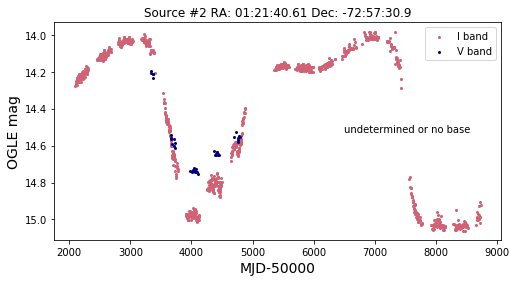

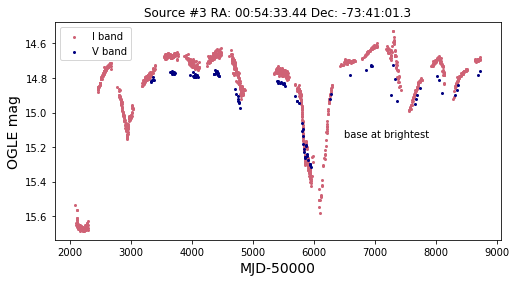

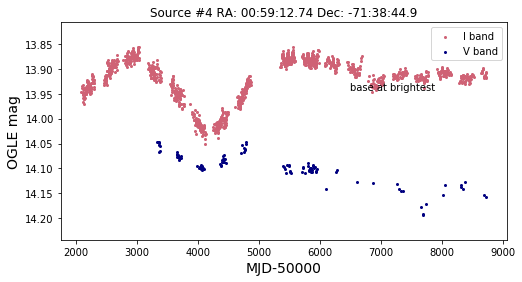

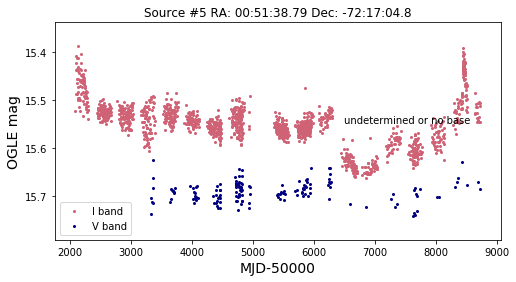

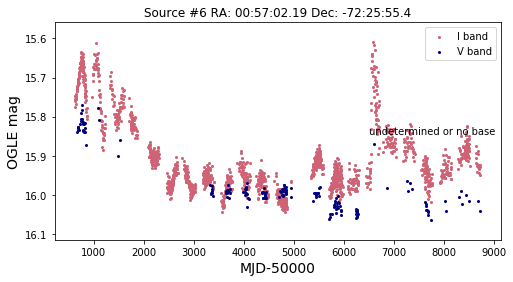

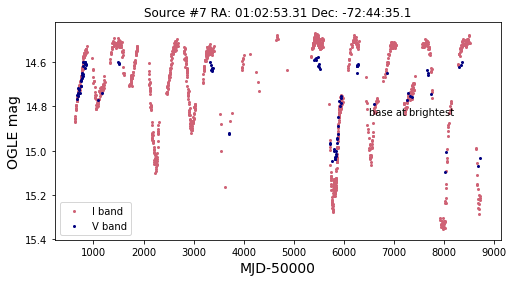

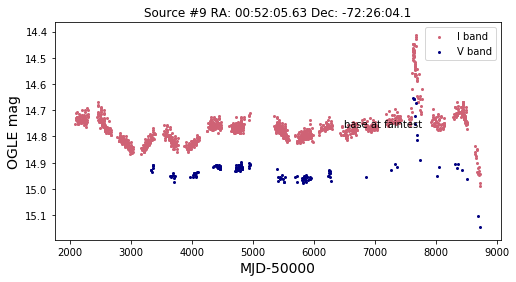

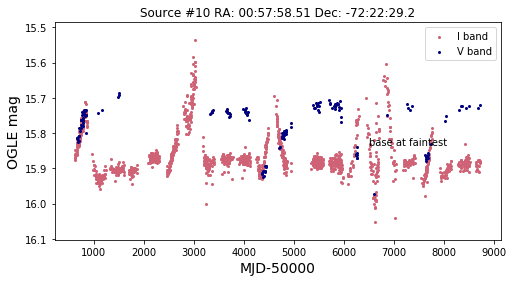

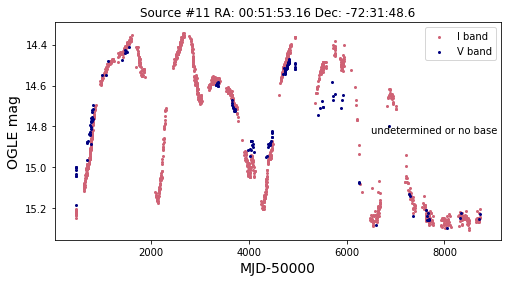

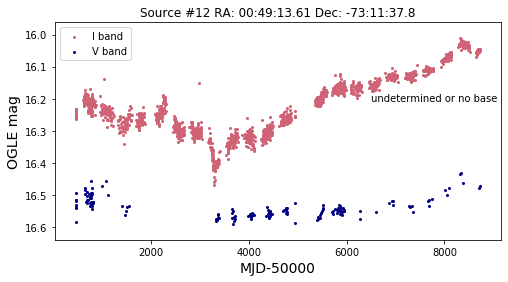

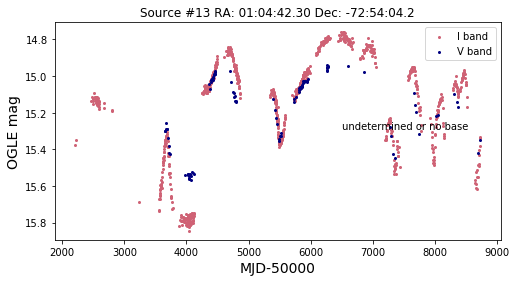

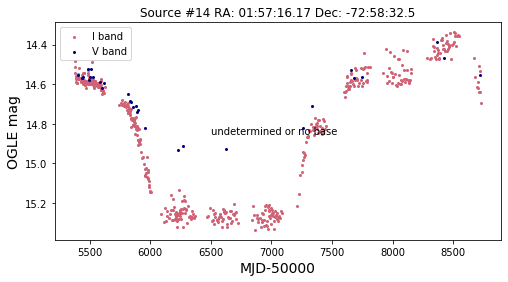

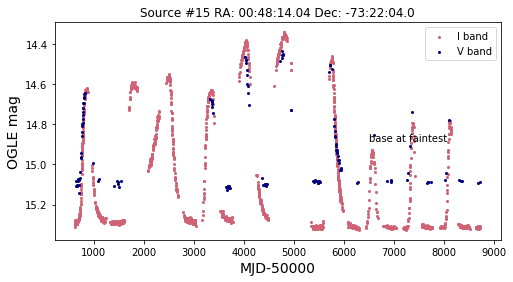

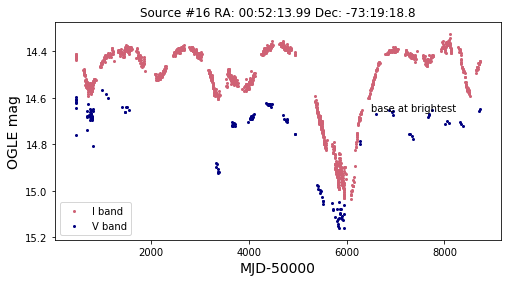

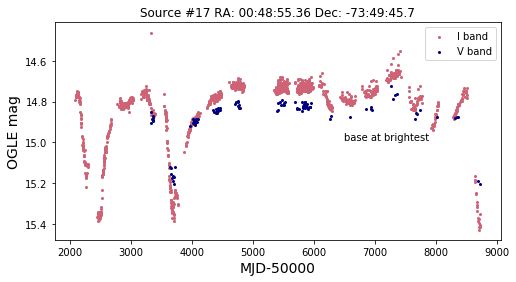

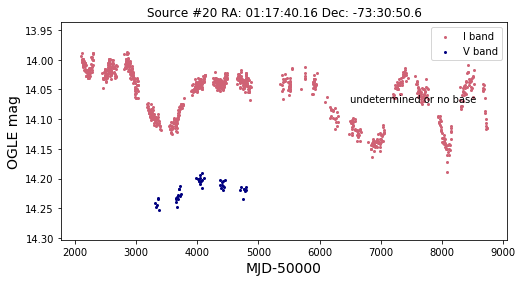

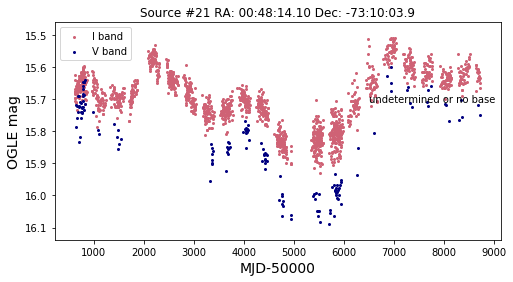

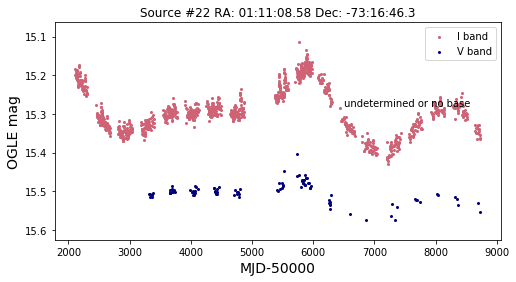

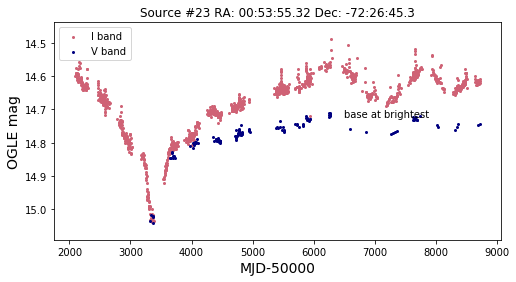

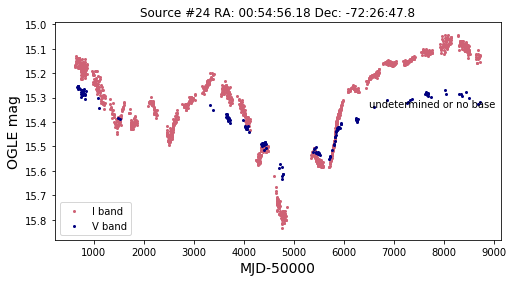

In [50]:
#happy with basically all of these
for s in nums[:20]:
    findbase(s,perc=95,cut=200,frac=True)

perhaps the max/min that 'fails' the test needs to be distributed in all epochs s.t. a very long-term trend doesn't justify a base determination

empty file for OIII I


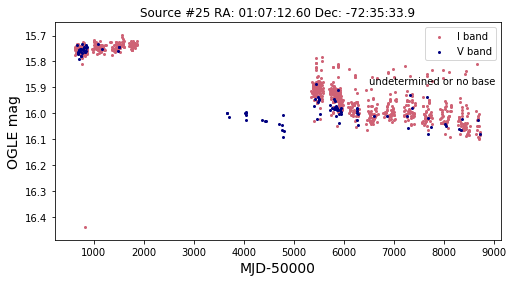

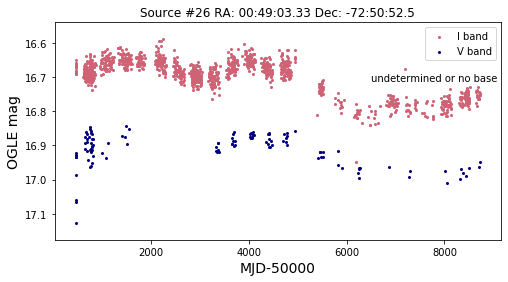

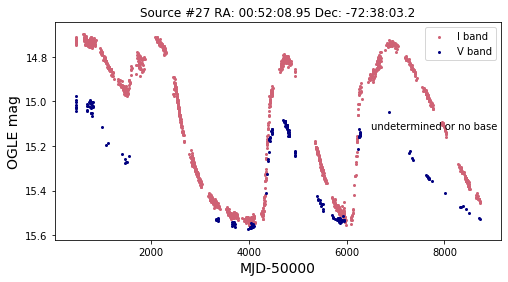

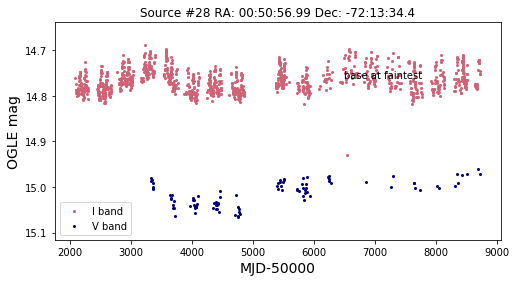

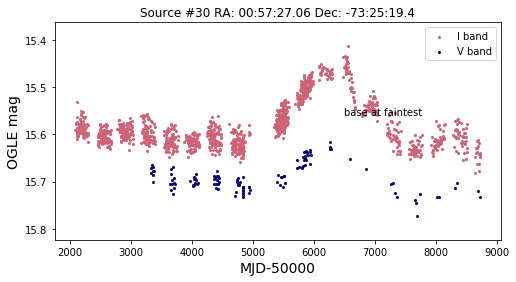

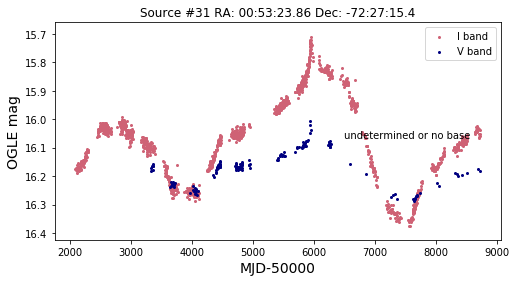

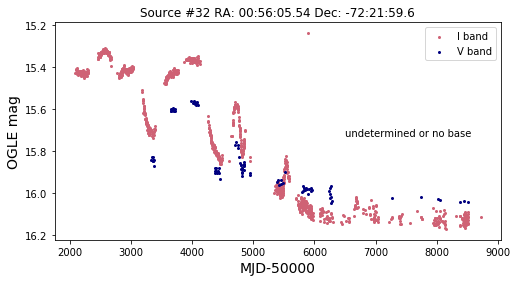

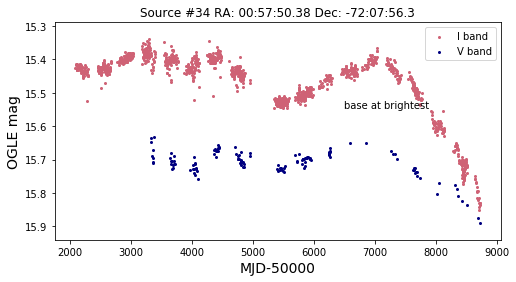

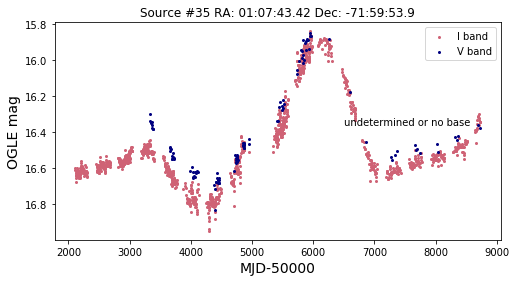

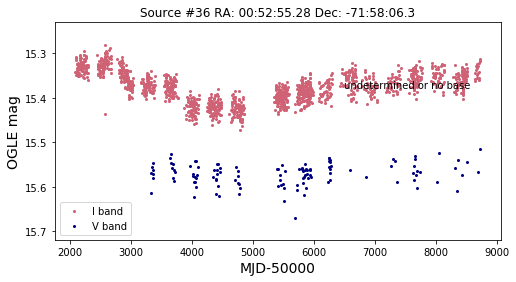

In [17]:
for s in nums[20:30]:
    findbase(s,perc=95,cut=200,frac=True,checkog=True)

# shape of flare
- compare width to height
- triangular?
    - width within some fraction of flare?
- **as a side task, work on also getting peak width of periodogram**

In [18]:
iband,vband = o.getIV(15,cross,stack=True,plot=False)

In [208]:
def peaks(iband,bright=True,window=100,btol=100,height=0.1,distance=30,plot=True,frac=0.3,spline=True):
    '''Use spline to find peaks (or troughs) in I band data
    bright: (bool) look for brightness peaks (so magnitude minima)
    TO DO: generalize to troughs
    spline: uses spline trend to find peaks rather than original data
    TO DO: condition to no longer use spline if peaks very different from data min/max'''
    flatten,trend = o.splinedetrend(iband,window=window,btol=btol,retspline=True)
    if bright and spline: diff = np.max(trend) - trend
    elif bright: diff = np.max(iband['I mag']) - iband['I mag']
    else: diff = trend
    peaks = signal.find_peaks(diff,height=height,distance=distance) 
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    if plot:
        plt.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=3)
        plt.ylim(maxi+.01,mini-.01)
    peakmag = iband['I mag'][peaks[0]]
    cut = maxi-(maxi-mini)*frac
    inds = np.where(peakmag<cut)[0]
    minpeaks = peakmag[inds]
    minloc = peaks[0][inds]
    if plot:
        plt.scatter(iband['MJD-50000'][peaks[0]],iband['I mag'][peaks[0]],label='deleted peaks')
        plt.scatter(iband['MJD-50000'][minloc],minpeaks,color='darkseagreen',label='kept peaks')
        plt.plot(iband['MJD-50000'],trend,color='black',alpha=0.3,label='spline')
        plt.legend()
    #decide what to return
    return trend,minloc #returns indices in iband of peaks

array([ 143,  315,  425,  668,  792,  946, 1112, 1348, 1460, 1569])

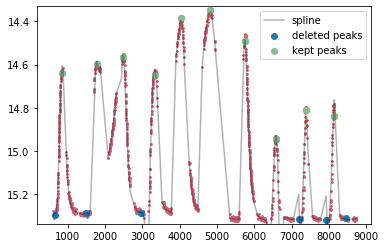

In [20]:
trend,minloc = peaks(iband)
minloc

#### peak widths
 - peak heights are not a reliable help

calculate peak heights using 95th percentile of window between peaks

In [201]:
def peakwidth(iband,trend,pinds,frac=0.5,bounds=False,plot=True,retheight=True,fs=(5,4),text=False,split=0.7,spline=False,wmin=50):
    '''find width of peak at some fraction of range (default: FWHM)
    bounds of peak can be passed in or found using...
    pinds: indices of peaks in iband
    bounds: (bool) use pinds as start and end dates of peaks rather than locs of peaks
    retheight: return height of peak as well'''
    #if bounds, pinds are start and end dates of peak
    if bounds:
        df = iband[iband['MJD-50000']>=pinds[0]]
        df = iband[iband['MJD-50000']<=pinds[1]]
    else:
        plocs = np.array(iband['MJD-50000'][pinds])
        df = iband[iband['MJD-50000']<plocs[0]+(plocs[1]-plocs[0])*split]
        len1 = len(df)
        df = df[df['MJD-50000']>plocs[0]-(plocs[1]-plocs[0])/2]
        len2 = len(df)
    if plot: 
        plt.figure(figsize=fs)
        plt.scatter(df['MJD-50000'],df['I mag'],color=pink)
        maxi,mini = np.max(df['I mag']),np.min(df['I mag'])
        plt.ylim(maxi+.02,mini-.02)
    #start ind 
    st = len1-len2
    end = len(df)+st
    half = np.min(df['I mag']) + (np.max(df['I mag']) - np.min(df['I mag']))*frac
    if plot:
        if spline: plt.plot(df['MJD-50000'],trend[st:end],color=pink)
        #draw line at half max or other fraction of range
        plt.axhline(half,color='grey')
    #interpolate spline for even coverage
    x = np.arange(df['MJD-50000'][0],df['MJD-50000'][-1])
    if spline: interp = np.interp(x,df['MJD-50000'],trend[st:end])
    else: interp = np.interp(x,df['MJD-50000'],df['I mag'])
    #find intersection of line and interpolated spline
    idx = np.argwhere(np.diff(np.sign(interp - half))).flatten()
    #find peak height
    height = np.max(df['I mag'])-np.min(df['I mag'])
    if len(idx)<2: #does not succesfully find two solutions
        if retheight: return np.nan,height
        else: return np.nan
    else: width = x[idx[1]]-x[idx[0]]
    #replace width if multple points before other side
    c = 2
    while width<wmin and len(idx)>c:
        width = x[idx[c]]-x[idx[0]]
        c+=1
    if width<wmin and retheight: return np.nan,height
    elif width< wmin: return np.nan
    if plot: 
        plt.scatter(x[idx], interp[idx], color='darkseagreen')
        lenx = len(x)
        if text: plt.text(x[idx[0]],np.max(iband['I mag'])-.04,f'width at {frac} of peak: {width:.2f} days')
        plt.ylabel('I mag',fontsize=14)
        plt.xlabel('MJD-50000',fontsize=14)
    if retheight: return width,height
    else: return width

In [147]:
def allwidths(iband,trend,pinds,frac=0.5,bounds=False,plot=True,retheight=True,wmin=50):
    '''loop through all peaks and calculate widths and heights
    TO DO: plot on subplots'''
    widths,heights = [],[]
    #final bound is last point of iband
    end = len(iband)-1
    pinds = np.concatenate([pinds,[end]])
    for p in range(len(pinds)-1):
        #get width and height of peak
        w,h = peakwidth(iband,trend,[pinds[p],pinds[p+1]],frac=frac,wmin=wmin,bounds=bounds,plot=plot,retheight=retheight)
        widths.append(w)
        heights.append(h)
    return widths, heights

In [23]:
minloc

array([ 143,  315,  425,  668,  792,  946, 1112, 1348, 1460, 1569])

[188.0,
 375.0,
 414.0,
 230.0,
 334.99999999999955,
 539.0,
 194.0,
 126.0,
 104.0,
 132.0]

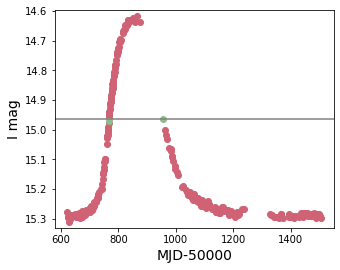

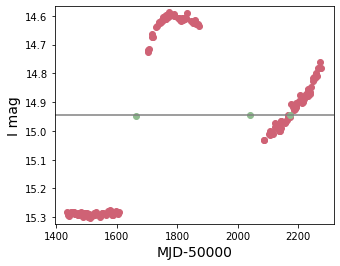

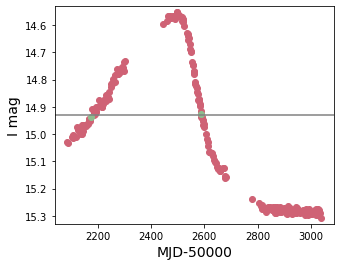

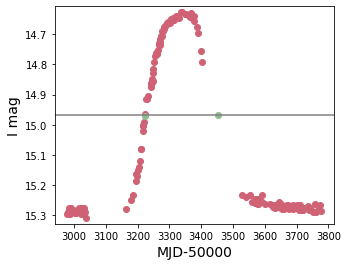

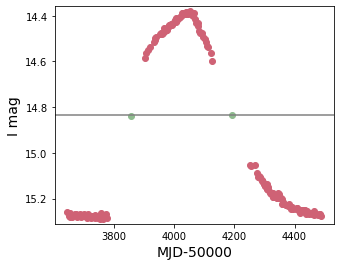

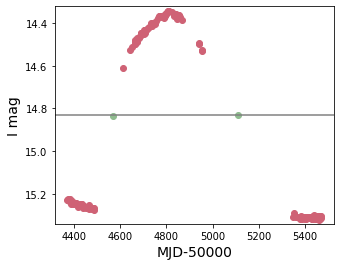

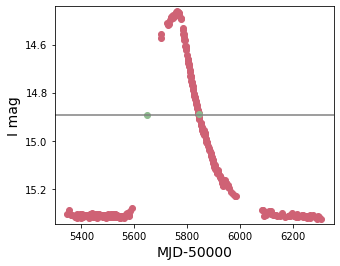

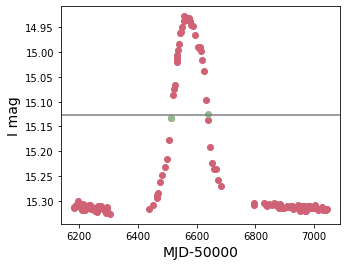

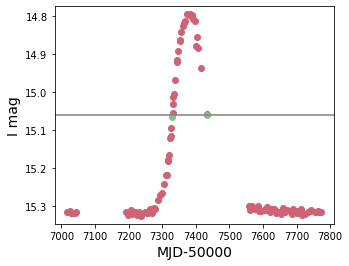

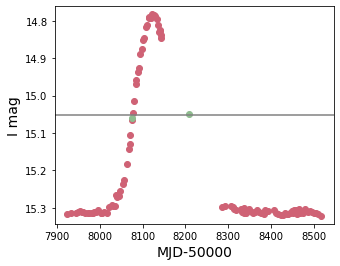

In [24]:
ws,hs = allwidths(iband,trend,minloc)
ws

In [25]:
#variation of peak distances -- compare these to widths
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
seps

array([925.17414, 702.15882, 843.66484, 707.11579, 787.95173, 919.30032,
       837.72239, 807.90837, 751.9861 ])

Text(0.5, 0, 'Peak Width (days)')

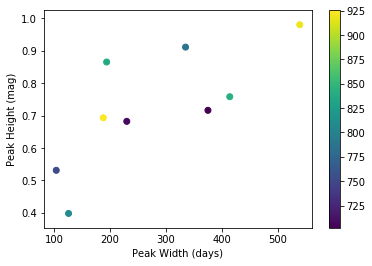

In [26]:
#relationship between FWHM and height
#color is distance between flare peak and previous flare peak
plt.scatter(ws[:-1],hs[:-1],c=seps)
plt.colorbar()
plt.ylabel('Peak Height (mag)')
plt.xlabel('Peak Width (days)')

goals with flare shape
- make similar plots to one above
- help with categorization
    - e.g. use ratio of width and height

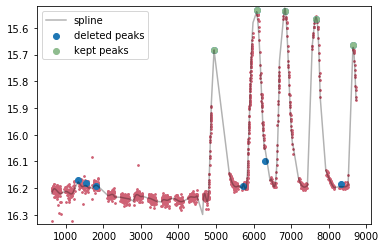

In [27]:
#repeat for others of this type
iband,vband = o.getIV(55,cross,stack=True,plot=False)
trend,minloc = peaks(iband)

In [28]:
ws,hs = allwidths(iband,trend,minloc[:-1],plot=False) #couldn't do final flare since it doesn't reach half max

In [29]:
ws

[351.0, 308.0, 298.0, 277.0]

In [30]:
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
seps

array([1135.99572,  746.00591,  832.80413,  988.21437])

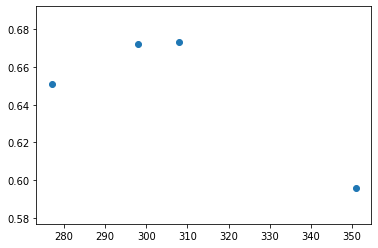

In [31]:
plt.scatter(ws,hs) #interesting but tough when sampling so uneven in first peak

Text(0.5, 0, 'Widths')

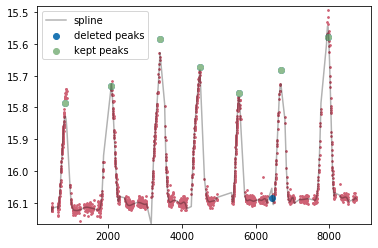

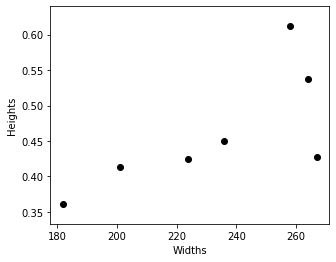

In [32]:
iband,vband = o.getIV(48,cross,stack=True,plot=False)
trend,minloc = peaks(iband)
ws,hs = allwidths(iband,trend,minloc,plot=False) 
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
plt.figure(figsize=(5,4))
plt.scatter(ws,hs,color='black')
plt.ylabel('Heights')
plt.xlabel('Widths')

#### part 2 sources in this category
- returns nan width if two solutions not identified

[1109.02151  929.70401  991.00405 1199.94623 1281.38015]


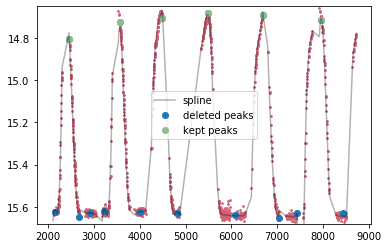

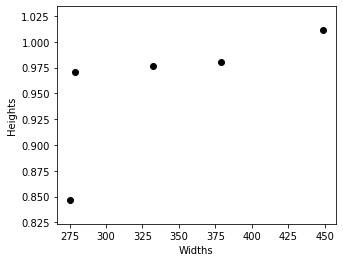

In [33]:
iband,vband = o.getIV(128,cross2,stack=True,plot=False,mlist=['OII I','OIII I','OIV I'])
trend,minloc = peaks(iband)
ws,hs = allwidths(iband,trend,minloc,plot=False) #last flare not completed
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
plt.figure(figsize=(5,4))
plt.scatter(ws,hs,color='black')
plt.ylabel('Heights')
plt.xlabel('Widths')
print(seps)

[742.02144 557.2607  708.03314 841.78439]


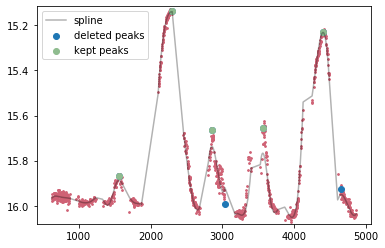

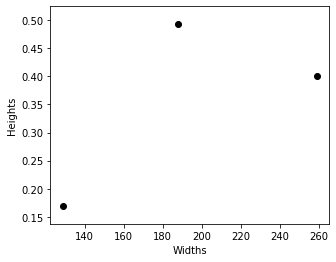

In [34]:
#needed to adjust frac on this one to get small peak -- this may be the case when amplitudes so variable

#and sampling uncelar for one
iband,vband = o.getIV(132,cross2,stack=True,plot=False,mlist=['OII I','OIII I','OIV I'])
trend,minloc = peaks(iband,frac=0.2)
ws,hs = allwidths(iband,trend,minloc,plot=False) #last flare not completed
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
plt.figure(figsize=(5,4))
plt.scatter(ws,hs,color='black')
plt.ylabel('Heights')
plt.xlabel('Widths')
print(seps)

#### a couple other sources

Text(0.5, 0, 'Widths')

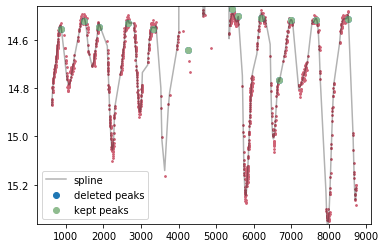

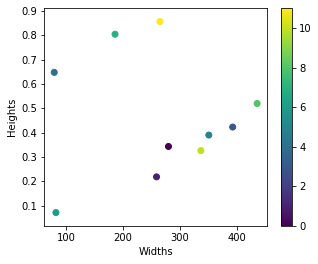

In [35]:
#try on other source
iband,vband = o.getIV(7,cross,stack=True,plot=False)
trend,minloc = peaks(iband)
#error for a flare after this
ws,hs = allwidths(iband,trend,minloc,plot=False) 
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
plt.figure(figsize=(5,4))
#get order of flares 
order = np.arange(len(ws))
# tims = np.array(tims)
plt.scatter(ws,hs,c=order)
plt.colorbar()
plt.ylabel('Heights')
plt.xlabel('Widths')

Text(0.5, 0, 'Widths')

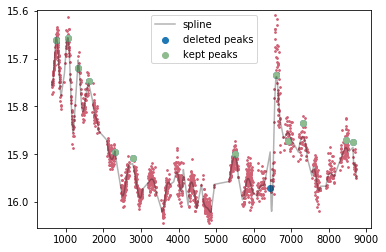

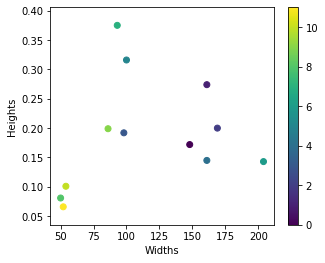

In [36]:
#try on other source
iband,vband = o.getIV(6,cross,stack=True,plot=False)
trend,minloc = peaks(iband)
#error for a flare after this
ws,hs = allwidths(iband,trend,minloc,plot=False) 
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
plt.figure(figsize=(5,4))
order = np.arange(len(ws))
plt.scatter(ws,hs,c=order)
plt.colorbar()
plt.ylabel('Heights')
plt.xlabel('Widths')

but these steps can easily fail
- maybe can play with parameters, but wouldn't run it automatically

### use to find periodogram peak widths

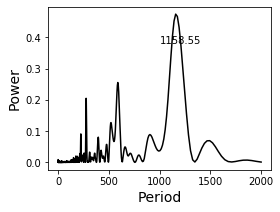

In [37]:
iband,vband = o.getIV(48,cross,stack=True,plot=False)
freq,power,bp = o.periodogram(iband,minp=2,maxp=2000,more=True,samples=10)

In [38]:
#identify peaks
reload(o)
pf = o.findpeaks(freq,power,sigma=20,distance=50,div=2,pkorder=True)

In [39]:
pf[:5]

,period,power,ind
0,1158.554972,0.474681,30
1,588.797822,0.255693,99
2,396.588908,0.080662,167
3,276.936561,0.205114,257
4,224.912833,0.091137,326


In [40]:
def pdwidth(pf,freq,power,ind=0,cut=10,retinds=False,interp=True):
    '''If cut doesn't work well, can use while loop to get indices outside of half max '''
    #half max
    half = pf.loc[ind]['power']/2 #half max
    #truncate indices used to find width
    find = int(pf.loc[ind]['ind'])
    st,end = find-cut,find+cut
    idx = np.argwhere(np.diff(np.sign(power[st:end] - half))).flatten()
    period = 1/freq
    width = period[st+idx[0]]-period[st+idx[1]]
    #if returning indices, use on period to get values and width
    if retinds: return [st+idx[1],st+idx[0]]
    else: return width

In [41]:
inds = []
for p in range(5):
    inds.append(pdwidth(pf,freq,power,ind=p,retinds=True))

In [42]:
inds

[[34, 25], [104, 94], [171, 163], [261, 251], [330, 322]]

full width: 148.90298576360783
full width: 42.01865312228858
full width: 15.236637578838724
full width: 9.348844261758643
full width: 4.899229895326243


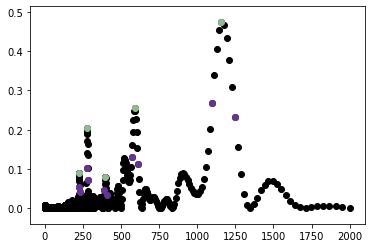

In [43]:
#plotting top five peaks
period = 1/freq
plt.scatter(period,power,color='black')
plt.scatter(pf['period'][:5],pf['power'][:5],color='darkseagreen')
for i in inds:
    plt.scatter(period[i],power[i],color='rebeccapurple')
    print(f'full width: {period[i[1]]-period[i[0]]}')

# identify all flares with faint base
- then seeing if other features can delineate between identified type and others


In [44]:
summ[np.isnan(summ['I IQR'])]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,V-I transition,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part,I IQR
0,1,19.271511,-73.443405,0.717,0.50,3.892,0.404107,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2.0,NaN
46,51,13.516111,-72.442345,341.900,0.57,0.000,0.615308,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN


In [45]:
nums[30:40]

37
38
39
40
41
44
45
46
47
48


In [257]:
nums = cross['src_n']
nums = np.array(nums)
#source that can't be read in
nums = nums[nums!=51]

In [258]:
nums

array([  2,   3,   4,   5,   6,   7,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  20,  21,  22,  23,  24,  25,  26,  27,  28,  30,  31,
        32,  34,  35,  36,  37,  38,  39,  40,  41,  44,  45,  46,  47,
        48,  49,  50,  52,  53,  54,  55,  56,  57,  58,  59,  60,  62,
        63,  64,  65, 125, 142])

In [259]:
#part1: faint base sources in part 1
bbs1 = []
fbs1 = []
for s in nums:
    base = findbase(s,perc=95,cut=200,frac=True,checkog=True,plot=False) 
    if base == 'base at faintest': fbs1.append(s)
    if base == 'base at brightest': bbs1.append(s)


empty file for OIII I


In [260]:
nums = cross2['src_n']
nums = nums[nums!=1]
#part1: faint base sources in part 1
fbs2 = []
bbs2 = []
for s in nums:
    base = findbase(s,cross=cross2,perc=95,cut=200,frac=True,checkog=True,plot=False) 
    if base == 'base at faintest': fbs2.append(s)
    if base == 'base at brightest': bbs2.append(s)

empty file for OII I
empty file for OIII I


In [77]:
fbs2

[19, 67, 111, 119, 126, 128, 132]

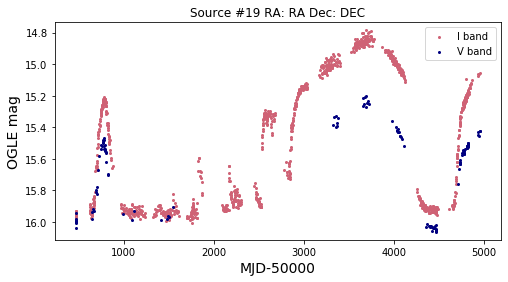

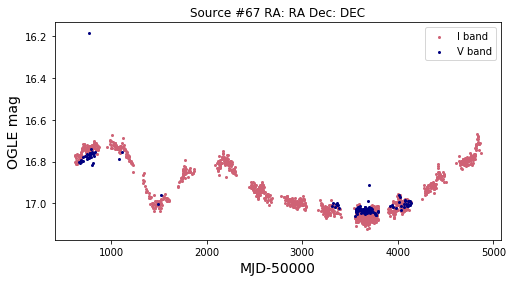

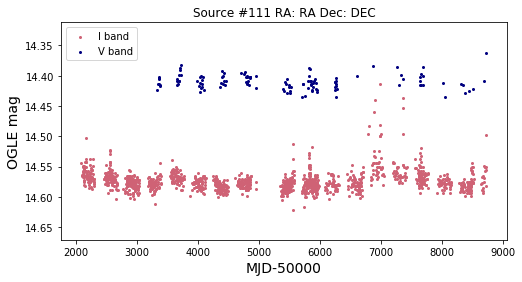

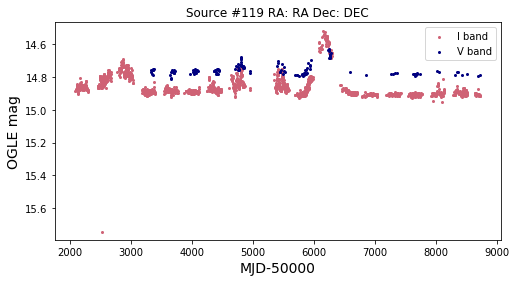

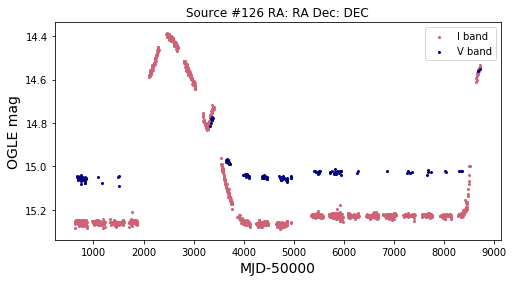

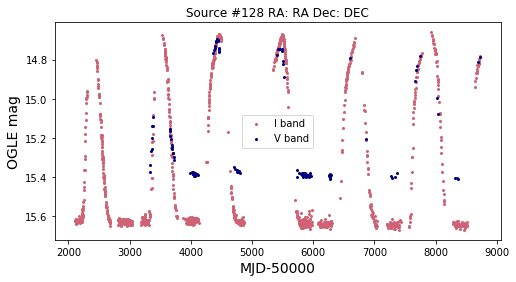

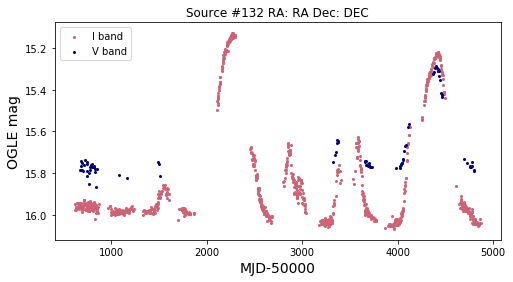

In [81]:
#plot part 2 sources with identified faint base
for f in fbs2:
    iband,vband = o.getIV(f,cross2,stack=True,both=True,plot=True,mlist=['OII I','OIII I','OIV I'])

In [236]:
#make df for each for features
fdf1 = pd.DataFrame(columns=['source','slope diff','mean width/height','max width/height','min width/height'])
fdf1['source'] = fbs1

fdf2 = pd.DataFrame(columns=['source','slope diff','mean width/height','max width/height','min width/height'])
fdf2['source'] = fbs2

for each source, calculate difference between slopes
- for the type, expect abs value of faint to be lower than bright
    - so positive is default

In [230]:
fdf1

,source,slope diff,mean width/height,max width/height
0,9,NaN,NaN,NaN
1,10,NaN,NaN,NaN
2,15,NaN,NaN,NaN
3,28,NaN,NaN,NaN
4,30,NaN,NaN,NaN
5,48,NaN,NaN,NaN
6,55,NaN,NaN,NaN
7,60,NaN,NaN,NaN
8,63,NaN,NaN,NaN


In [532]:
fdf1['power'] = np.zeros(len(fdf1))
fdf2['power'] = np.zeros(len(fdf2))

In [237]:
diffs = []
for f in fbs1:
    fslope,bslope = div_cm(f,cross=cross,interp=[],vband=[],frac=0.3,plot=False,findcorr=False)
    diffs.append(np.abs(bslope) - np.abs(fslope))
fdf1['slope diff'] = diffs

I and V-I correlation: -0.667340526448103
V and V-I correlation: -0.39477937412506486
steeper when brighter
I and V-I correlation: -0.6832617411444406
V and V-I correlation: 0.7737722449334529
steeper when brighter
I and V-I correlation: -0.9372414483256165
V and V-I correlation: -0.8515095648198383
steeper when brighter
I and V-I correlation: -0.19384500140770167
V and V-I correlation: 0.5100391042312166
steeper when brighter
I and V-I correlation: -0.8565184040914818
V and V-I correlation: -0.4252439926010499
steeper when brighter
I and V-I correlation: -0.9708981007790428
V and V-I correlation: -0.7540319474968079
steeper when brighter
I and V-I correlation: -0.9784986197610509
V and V-I correlation: -0.8992727263873777
steeper when brighter
I and V-I correlation: -0.7903821327759735
V and V-I correlation: -0.572353612041409
steeper when brighter
I and V-I correlation: -0.949075347309229
V and V-I correlation: -0.871228200471551
steeper when brighter


In [238]:
diffs = []
for f in fbs2:
    fslope,bslope = div_cm(f,cross=cross2,interp=[],vband=[],frac=0.3,plot=False,findcorr=False)
    diffs.append(np.abs(bslope) - np.abs(fslope))
fdf2['slope diff'] = diffs

I and V-I correlation: -0.9634952657054523
V and V-I correlation: -0.9179149262819041
steeper when brighter
I and V-I correlation: -0.32756498369748815
V and V-I correlation: 0.10889980040748493
steeper when fainter
I and V-I correlation: -0.4499013176301471
V and V-I correlation: 0.3944493577891568
steeper when brighter
I and V-I correlation: -0.9562602917034363
V and V-I correlation: -0.8245738782996825
steeper when brighter
I and V-I correlation: -0.9659853103847417
V and V-I correlation: -0.8976564703240444
steeper when brighter
I and V-I correlation: -0.945568932143824
V and V-I correlation: -0.8840279171742701
steeper when brighter
I and V-I correlation: -0.9647345966389136
V and V-I correlation: -0.9002903341106792
steeper when brighter


final feature: identify peaks; get width/height ratios

In [239]:
fbs1

[9, 10, 15, 28, 30, 48, 55, 60, 63]

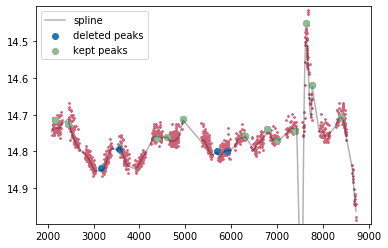

In [533]:
iband,vband = o.getIV(9,cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.35)
ws,hs = allwidths(iband,trend,minloc,frac=0.5,bounds=False,plot=False,retheight=True)

In [536]:
fdf1.columns

Index(['source', 'slope diff', 'mean width/height', 'max width/height',
       'min width/height', 'power'],
      dtype='object')

In [537]:
#get peak of periodogram
freq,power,bp = o.periodogram(iband,minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][:1] = np.max(power)

In [242]:
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
fdf1['mean width/height'][:1] = np.nanmean(ratio)
fdf1['max width/height'][:1] = np.nanmax(ratio)
fdf1['min width/height'][:1] = np.nanmin(ratio)

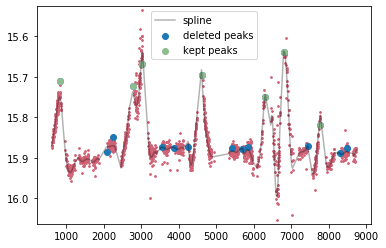

In [542]:
iband,vband = o.getIV(10,cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.4)
ws,hs = allwidths(iband,trend,minloc,frac=0.5,bounds=False,plot=False,retheight=True)

In [543]:
#get peak of periodogram
freq,power,bp = o.periodogram(iband,minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][1:2] = np.max(power)

In [244]:
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
fdf1['mean width/height'][1:2] = np.nanmean(ratio)
fdf1['max width/height'][1:2] = np.nanmax(ratio)
fdf1['min width/height'][1:2] = np.nanmin(ratio)

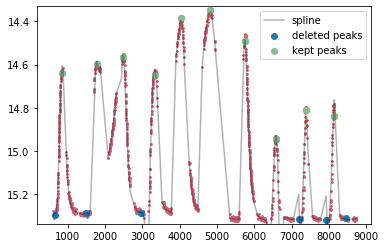

In [544]:
iband,vband = o.getIV(fbs1[2],cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.3)
ws,hs = allwidths(iband,trend,minloc,frac=0.5,bounds=False,plot=False,retheight=True)
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
fdf1['mean width/height'][2:3] = np.nanmean(ratio)
fdf1['max width/height'][2:3] = np.nanmax(ratio)
fdf1['min width/height'][2:3] = np.nanmin(ratio)

#get peak of periodogram
freq,power,bp = o.periodogram(iband,minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][2:3] = np.max(power)

[]


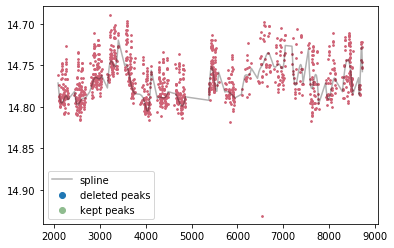

In [545]:
iband,vband = o.getIV(fbs1[3],cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.3)
ws,hs = allwidths(iband,trend,minloc,frac=0.5,bounds=False,plot=False,retheight=True)
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
fdf1['mean width/height'][3:4] = np.nanmean(ratio)
print(ratio)

#get peak of periodogram
freq,power,bp = o.periodogram(iband,minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][3:4] = np.max(power)

[176.]


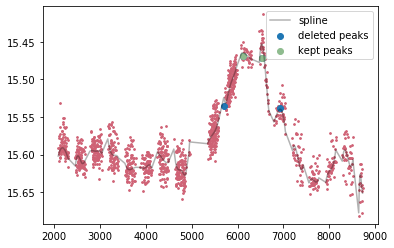

In [546]:
#want it to just identify one big peak
iband,vband = o.getIV(fbs1[4],cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.75)
ws,hs = allwidths(iband,trend,[1060],frac=0.5,bounds=False,plot=False,retheight=True)
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
#not recognizing how wide the peak is
print(ws)
fdf1['mean width/height'][4:5] = np.nanmean(ratio)
fdf1['max width/height'][4:5] = np.nanmax(ratio)
fdf1['min width/height'][4:5] = np.nanmin(ratio)

#get peak of periodogram
freq,power,bp = o.periodogram(iband,minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][4:5] = np.max(power)

[201. 267. 264. 236. 182. 224. 258.]


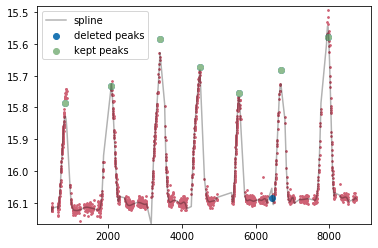

In [547]:
iband,vband = o.getIV(fbs1[5],cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.3)
ws,hs = allwidths(iband,trend,minloc,frac=0.5,bounds=False,plot=False,retheight=True)
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
print(ws)
fdf1['mean width/height'][5:6] = np.nanmean(ratio)
fdf1['max width/height'][5:6] = np.nanmax(ratio)
fdf1['min width/height'][5:6] = np.nanmin(ratio)

#get peak of periodogram
freq,power,bp = o.periodogram(iband,minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][5:6] = np.max(power)

[351. 308. 298. 277.  nan]


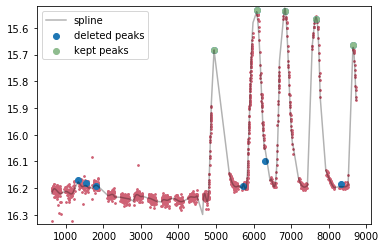

In [557]:
iband,vband = o.getIV(fbs1[6],cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.3)
ws,hs = allwidths(iband,trend,minloc,frac=0.5,bounds=False,plot=False,retheight=True)
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
print(ws)
fdf1['mean width/height'][6:7] = np.nanmean(ratio)
fdf1['max width/height'][6:7] = np.nanmax(ratio)
fdf1['min width/height'][6:7] = np.nanmin(ratio)

#get peak of periodogram
freq,power,bp = o.periodogram(iband[700:],minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][6:7] = np.max(power)

[395.  nan  nan  nan  nan 389.  nan  nan  nan  nan 383. 106.  nan]


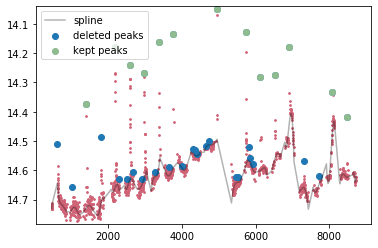

In [549]:
iband,vband = o.getIV(fbs1[7],cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.4,spline=False)
ws,hs = allwidths(iband,trend,minloc,frac=0.5,bounds=False,plot=False,retheight=True)
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
print(ws)
fdf1['mean width/height'][7:8] = np.nanmean(ratio)
fdf1['max width/height'][7:8] = np.nanmax(ratio)
fdf1['min width/height'][7:8] = np.nanmin(ratio)

#get peak of periodogram
freq,power,bp = o.periodogram(iband,minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][7:8] = np.max(power)

[ nan  nan 610.  nan  nan]


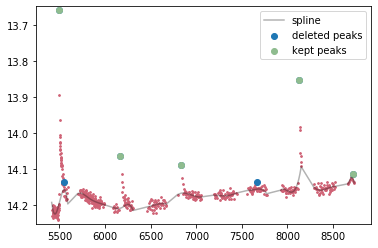

In [550]:
iband,vband = o.getIV(fbs1[8],cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.2,spline=False)
ws,hs = allwidths(iband,trend,minloc,frac=0.5,bounds=False,plot=False,retheight=True)
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
print(ws)
fdf1['mean width/height'][8:9] = np.nanmean(ratio)
fdf1['max width/height'][8:9] = np.nanmax(ratio)
fdf1['min width/height'][8:9] = np.nanmin(ratio)

#get peak of periodogram
freq,power,bp = o.periodogram(iband,minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][8:9] = np.max(power)

seems to get widths wrong for really sharp peaks
- turned off use of spline for sharp b/c spline doesn't model the peaks
- can write this into function

- b/c of plots below, for now not going to repeat for part 2 sources

#### analyze table

In [551]:
fdf1

,source,slope diff,mean width/height,max width/height,min width/height,power
0,9,0.388675,900.519,2212.77,217.27,0.203506
1,10,0.398631,587.287,1093.12,273.707,0.203506
2,15,0.306921,357.643,550,195.857,0.415984
3,28,0.382840,NaN,NaN,NaN,0.152858
4,30,1.226801,733.333,733.333,733.333,0.155127
5,48,1.534020,511.593,625.293,421.569,0.475541
6,55,1.328000,478.883,588.926,425.499,0.166462
7,60,1.271252,700.956,989.975,354.515,0.130178
8,63,2.273598,4586.47,4586.47,4586.47,0.109079


posx and posy should be finite values
posx and posy should be finite values


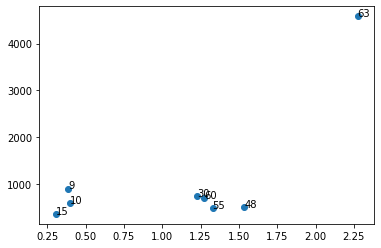

In [253]:
plt.scatter(fdf1['slope diff'],fdf1['mean width/height'])
for f in range(len(fdf1)):
    plt.text(fdf1.loc[f]['slope diff'],fdf1.loc[f]['mean width/height'],str(fdf1.loc[f]['source']))
#grouping of 15,55,48?

posx and posy should be finite values
posx and posy should be finite values


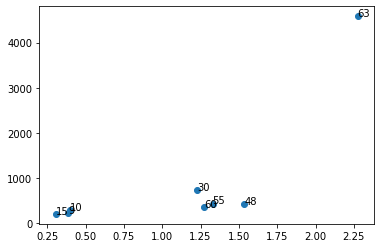

In [255]:
plt.scatter(fdf1['slope diff'],fdf1['min width/height'])
for f in range(len(fdf1)):
    plt.text(fdf1.loc[f]['slope diff'],fdf1.loc[f]['min width/height'],str(fdf1.loc[f]['source']))
#grouping of 15,55,48?

posx and posy should be finite values
posx and posy should be finite values


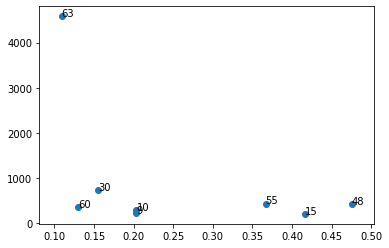

In [558]:
plt.scatter(fdf1['power'],fdf1['min width/height'])
for f in range(len(fdf1)):
    plt.text(fdf1.loc[f]['power'],fdf1.loc[f]['min width/height'],str(fdf1.loc[f]['source']))

#### compare slope diffs to population with base at brightest

In [263]:
bdf1 = pd.DataFrame(columns=['source','slope diff'])
bdf1['source'] = bbs1

bdf2 = pd.DataFrame(columns=['source','slope diff'])
bdf2['source'] = bbs2

In [265]:
diffs = []
for f in bbs1:
    fslope,bslope = div_cm(f,cross=cross,interp=[],vband=[],frac=0.3,plot=False,findcorr=False)
    diffs.append(np.abs(bslope) - np.abs(fslope))
bdf1['slope diff'] = diffs

I and V-I correlation: -0.8002922261337712
V and V-I correlation: -0.6698593996852642
steeper when fainter
I and V-I correlation: -0.883934340856408
V and V-I correlation: 0.6471296353848744
steeper when fainter
I and V-I correlation: -0.9670343623561133
V and V-I correlation: -0.9225217209125162
steeper when brighter
I and V-I correlation: -0.28392614544546685
V and V-I correlation: 0.1227097449647219
steeper when fainter
I and V-I correlation: -0.9743333607524376
V and V-I correlation: -0.9241167283255649
steeper when fainter
I and V-I correlation: -0.9273513917435414
V and V-I correlation: -0.8016300560930327
steeper when brighter
I and V-I correlation: -0.8996473434922264
V and V-I correlation: -0.4705792987062251
steeper when fainter
I and V-I correlation: 0.008207309264156904
V and V-I correlation: 0.1943980841976312
steeper when fainter
I and V-I correlation: -0.8678520855167449
V and V-I correlation: -0.7253066994414351
steeper when fainter
I and V-I correlation: -0.66873745697

In [266]:
diffs = []
for f in bbs2:
    fslope,bslope = div_cm(f,cross=cross2,interp=[],vband=[],frac=0.3,plot=False,findcorr=False)
    diffs.append(np.abs(bslope) - np.abs(fslope))
bdf2['slope diff'] = diffs

I and V-I correlation: -0.6056653161259252
V and V-I correlation: 0.08561860739395792
steeper when brighter
I and V-I correlation: -0.8816222525107474
V and V-I correlation: 0.15610819642368973
steeper when brighter
empty file for OII I
I and V-I correlation: nan
V and V-I correlation: 1.0
I and V-I correlation: -0.14960268017224718
V and V-I correlation: 0.9182068428667877
steeper when fainter
I and V-I correlation: -0.7418541628472648
V and V-I correlation: -0.4623167530237583
steeper when fainter
I and V-I correlation: -0.9149324003847996
V and V-I correlation: -0.5085433409713094
steeper when brighter
I and V-I correlation: -0.3634415884802355
V and V-I correlation: 0.5967636297255688
steeper when brighter


In [273]:
allbdiff = np.concatenate([bdf1['slope diff'],bdf2['slope diff']])

In [274]:
allfdiff = np.concatenate([fdf1['slope diff'],fdf2['slope diff']])

Text(0.5, 0, 'Bright CM Slope - Faint CM Slope')

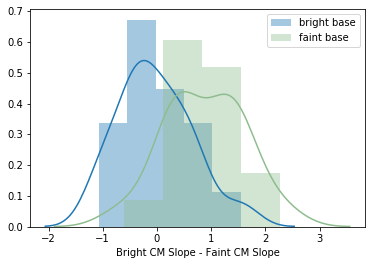

In [278]:
a = sb.distplot(allbdiff,label='bright base')

a = sb.distplot(allfdiff,color='darkseagreen',label='faint base')
plt.legend()
plt.xlabel('Bright CM Slope - Faint CM Slope')

possible difference but doesn't appear as significant, at least not enough to predict

In [280]:
scipy.stats.ttest_ind(allfdiff,allbdiff)

Ttest_indResult(statistic=3.6759441867575835, pvalue=0.0008910219479096046)

# loops/multiple V-I for single I 
- connection to certain features?

# continuous amplitude change
- use peak heights from function above to check if amplitudes monotonically changing

# look for periodicity in 15,55,48,128,132
- then other sources: 73,86,97,128
- look for changing period in 72

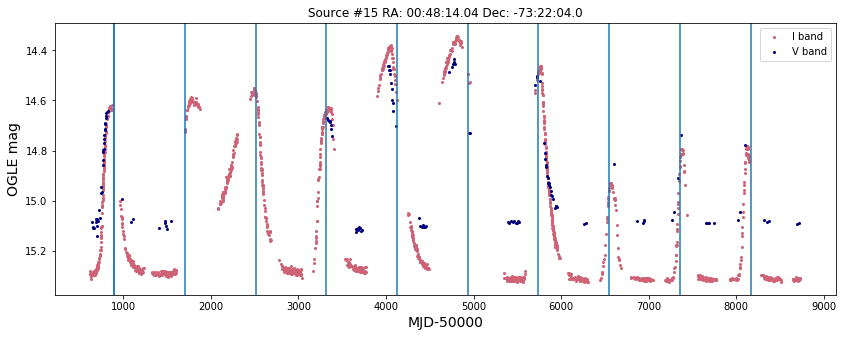

In [299]:
#15
ilist,vlist = o.getIV(15,cross,stack=False,plot=True,figsize=(14,5))
iband = vstack(ilist)
plt.axvline(900)
for i in range(10):
    plt.axvline(900+807*i)

sometimes under-predicts, sometimes over-predicts 

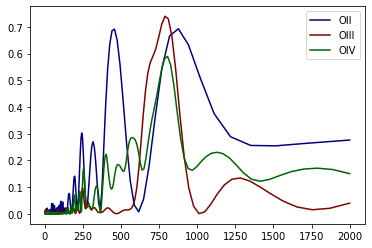

In [301]:
f1,p1,bp = o.periodogram(ilist[0],maxp=2000,more=True,plot=False)
f2,p2,bp = o.periodogram(ilist[1],maxp=2000,more=True,plot=False)
f3,p3,bp = o.periodogram(ilist[2],maxp=2000,more=True,plot=False)
plt.plot(1/f1,p1,color='navy',label='OII')
plt.plot(1/f2,p2,color='maroon',label='OIII')
plt.plot(1/f3,p3,color='darkgreen',label='OIV')
plt.legend()

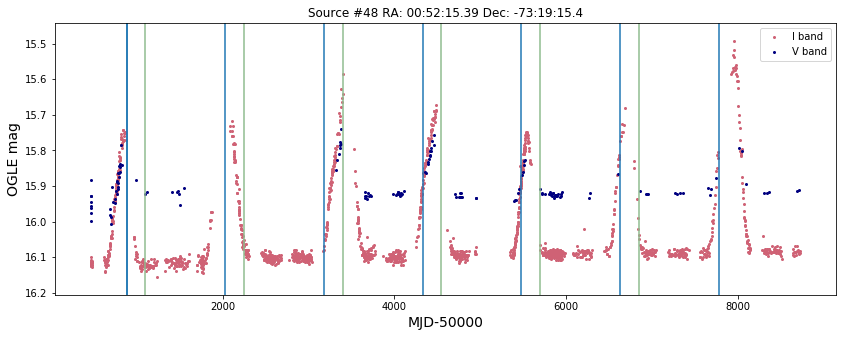

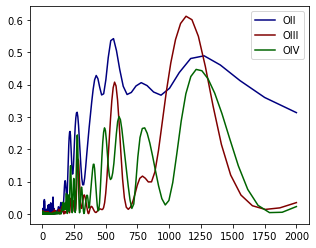

In [313]:
#48
ilist,vlist = o.getIV(48,cross,stack=False,plot=True,figsize=(14,5))
iband = vstack(ilist)
plt.axvline(880)
for i in range(7):
    plt.axvline(880+1150*i)
for i in range(-2,4):
    plt.axvline(3400+1150*i,color='darkseagreen')
f1,p1,bp = o.periodogram(ilist[0],maxp=2000,more=True,plot=False)
f2,p2,bp = o.periodogram(ilist[1],maxp=2000,more=True,plot=False)
f3,p3,bp = o.periodogram(ilist[2],maxp=2000,more=True,plot=False)
plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='OII')
plt.plot(1/f2,p2,color='maroon',label='OIII')
plt.plot(1/f3,p3,color='darkgreen',label='OIV')
plt.legend()

also not periodic

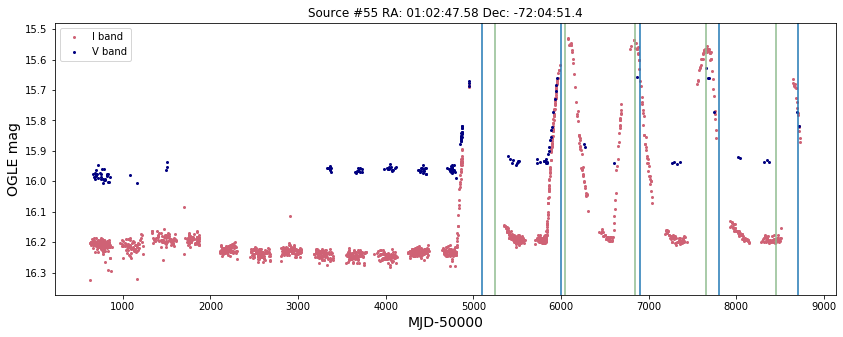

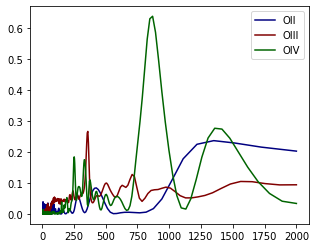

In [321]:
ilist,vlist = o.getIV(55,cross,stack=False,plot=True,figsize=(14,5))
iband = vstack(ilist)
for i in range(5):
    plt.axvline(5100+900*i)
for i in range(-1,4):
    plt.axvline(6050+800*i,color='darkseagreen')
f1,p1,bp = o.periodogram(ilist[0],maxp=2000,more=True,plot=False)
f2,p2,bp = o.periodogram(ilist[1],maxp=2000,more=True,plot=False)
f3,p3,bp = o.periodogram(ilist[2],maxp=2000,more=True,plot=False)
plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='OII')
plt.plot(1/f2,p2,color='maroon',label='OIII')
plt.plot(1/f3,p3,color='darkgreen',label='OIV')
plt.legend()

800 days works for a couple, but is too low on either side

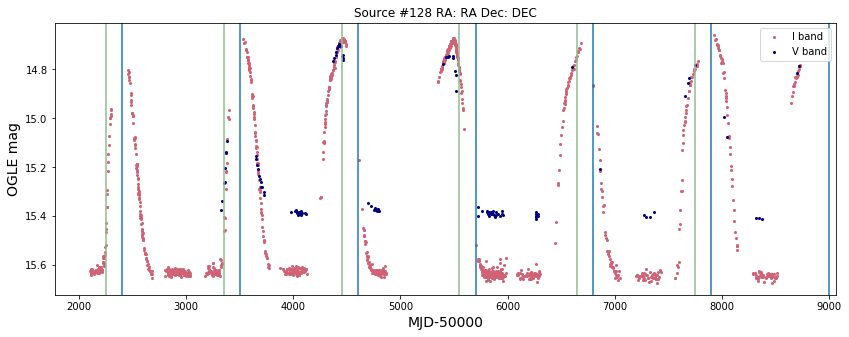

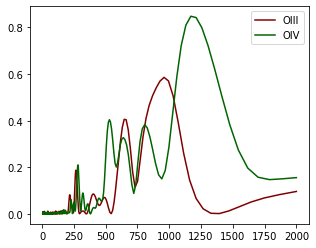

In [333]:
ilist,vlist = o.getIV(128,cross2,stack=False,plot=True,figsize=(14,5),mlist=['OII I','OIII I','OIV I'])
iband = vstack(ilist)
for i in range(7):
    plt.axvline(2400+1100*i)
for i in range(-2,4):
    plt.axvline(4450+1100*i,color='darkseagreen')
f1,p1,bp = o.periodogram(ilist[0],maxp=2000,more=True,plot=False)
f2,p2,bp = o.periodogram(ilist[1],maxp=2000,more=True,plot=False)
plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='maroon',label='OIII')
plt.plot(1/f2,p2,color='darkgreen',label='OIV')
plt.legend()

longer periods at start and end

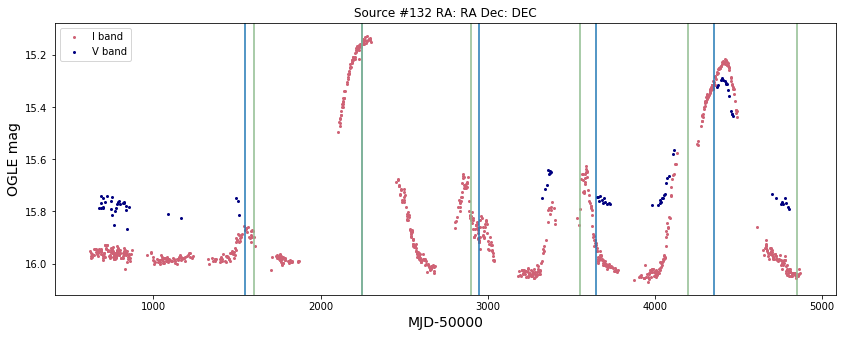

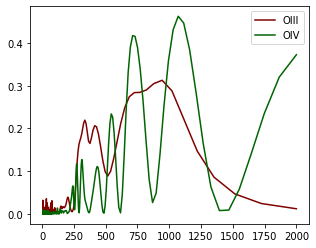

In [350]:
ilist,vlist = o.getIV(132,cross2,stack=False,plot=True,figsize=(14,5),mlist=['OII I','OIII I','OIV I'])
# iband = vstack(ilist)
for i in range(5):
    plt.axvline(1550+700*i)
for i in range(-1,5):
    plt.axvline(2250+650*i,color='darkseagreen')
f1,p1,bp = o.periodogram(ilist[0],maxp=2000,more=True,plot=False)
f2,p2,bp = o.periodogram(ilist[1],maxp=2000,more=True,plot=False)
plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='maroon',label='OIII')
plt.plot(1/f2,p2,color='darkgreen',label='OIV')
plt.legend()

# follow up: 86,97,72


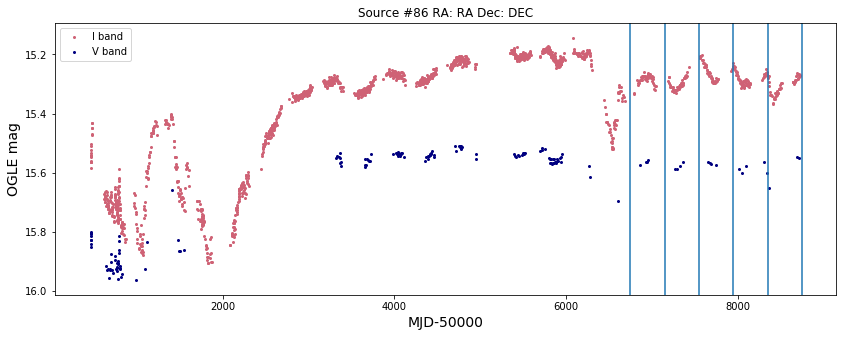

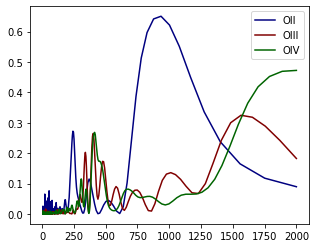

In [362]:
#mlist =['OII I','OIII I','OIV I']
ilist,vlist = o.getIV(86,cross2,stack=False,plot=True,figsize=(14,5),mlist=['OII I','OIII I','OIV I'])
for i in range(-2,4):
    plt.axvline(7550+400*i)
# for i in range(-1,5):
#     plt.axvline(2250+650*i,color='darkseagreen')
f1,p1,bp = o.periodogram(ilist[0],maxp=2000,more=True,plot=False)
f2,p2,bp = o.periodogram(ilist[1],maxp=2000,more=True,plot=False)
f3,p3,bp = o.periodogram(ilist[2],maxp=2000,more=True,plot=False)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='OII')
plt.plot(1/f2,p2,color='maroon',label='OIII')
plt.plot(1/f3,p3,color='darkgreen',label='OIV')
plt.legend()

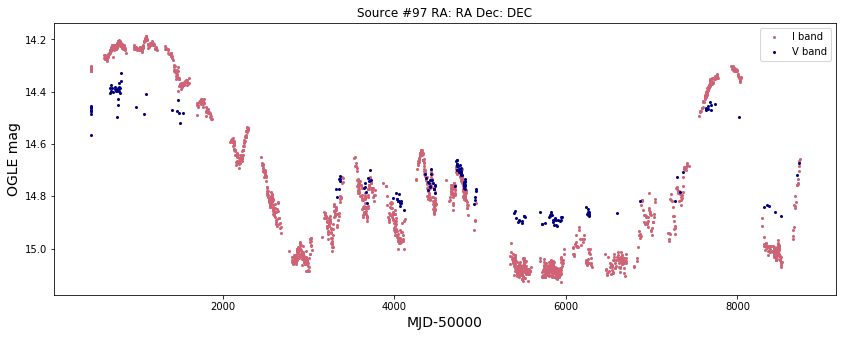

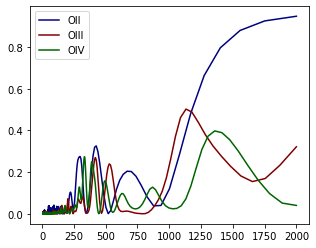

In [364]:
#mlist =['OII I','OIII I','OIV I']
ilist,vlist = o.getIV(97,cross2,stack=False,plot=True,figsize=(14,5),mlist=['OII I','OIII I','OIV I'])
# for i in range(-2,4):
#     plt.axvline(7550+400*i)
# for i in range(-1,5):
#     plt.axvline(2250+650*i,color='darkseagreen')
f1,p1,bp = o.periodogram(ilist[0],maxp=2000,more=True,plot=False)
f2,p2,bp = o.periodogram(ilist[1],maxp=2000,more=True,plot=False)
f3,p3,bp = o.periodogram(ilist[2],maxp=2000,more=True,plot=False)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='OII')
plt.plot(1/f2,p2,color='maroon',label='OIII')
plt.plot(1/f3,p3,color='darkgreen',label='OIV')
plt.legend()

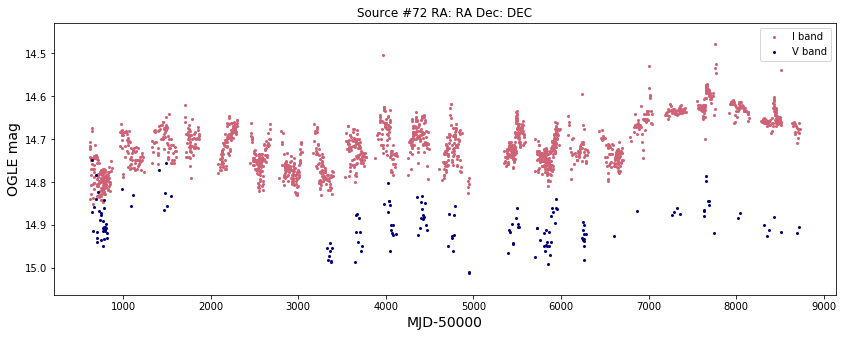

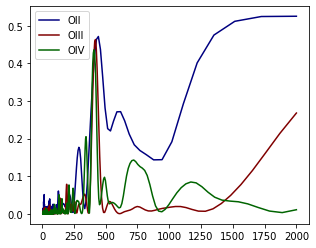

In [367]:
ilist,vlist = o.getIV(72,cross2,stack=False,plot=True,figsize=(14,5),mlist=['OII I','OIII I','OIV I'])
# for i in range(-2,4):
#     plt.axvline(7550+400*i)
# for i in range(-1,5):
#     plt.axvline(2250+650*i,color='darkseagreen')
f1,p1,bp = o.periodogram(ilist[0],maxp=2000,more=True,plot=False)
f2,p2,bp = o.periodogram(ilist[1],maxp=2000,more=True,plot=False)
f3,p3,bp = o.periodogram(ilist[2],maxp=2000,more=True,plot=False)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='OII')
plt.plot(1/f2,p2,color='maroon',label='OIII')
plt.plot(1/f3,p3,color='darkgreen',label='OIV')
plt.legend()

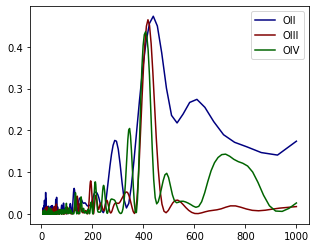

In [369]:
#decreasing period?
f1,p1,bp1 = o.periodogram(ilist[0],maxp=1000,more=True,plot=False)
f2,p2,bp2 = o.periodogram(ilist[1],maxp=1000,more=True,plot=False)
f3,p3,bp3 = o.periodogram(ilist[2],maxp=1000,more=True,plot=False)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='OII')
plt.plot(1/f2,p2,color='maroon',label='OIII')
plt.plot(1/f3,p3,color='darkgreen',label='OIV')
plt.legend()

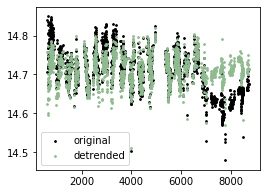

In [397]:
#phase fold each
iband = vstack(ilist)
o.detrend(iband,window=201,plot=True)
o.detrend(ilist[0],window=201,plot=False)
o.detrend(ilist[1],window=201,plot=False)
o.detrend(ilist[2],window=201,plot=False)

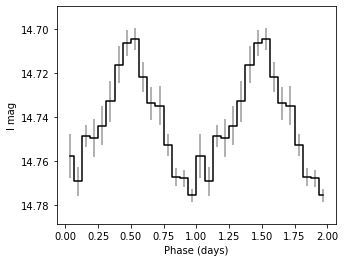

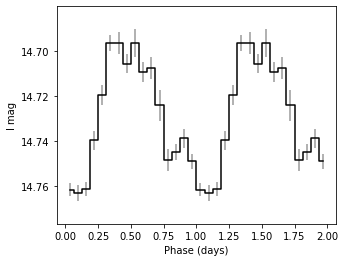

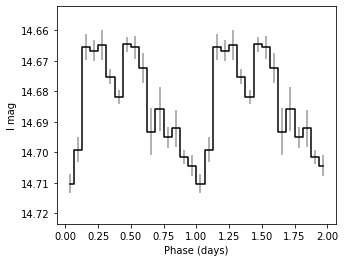

In [416]:
plt.figure(figsize=(5,4))
o.phasestep(ilist[0],bp1,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=70,sterr=True,divide=True,label='')
plt.figure(figsize=(5,4))
o.phasestep(ilist[1],bp2,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')
plt.figure(figsize=(5,4))
o.phasestep(ilist[2],bp3,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=-130,sterr=True,divide=True,label='')


first two look good on all three but phase-shift!

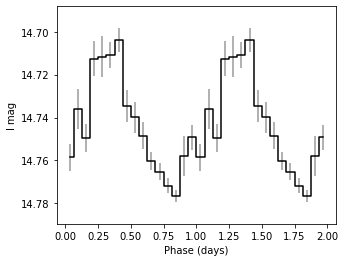

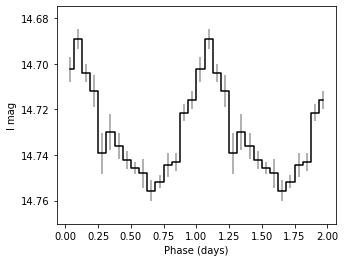

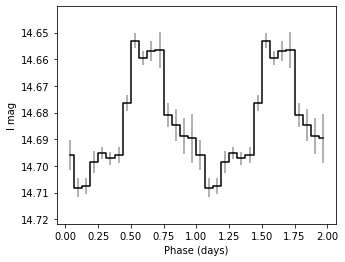

In [421]:
#use first on each 
plt.figure(figsize=(5,4))
o.phasestep(ilist[0],bp1,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')
plt.figure(figsize=(5,4))
o.phasestep(ilist[1],bp1,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')
plt.figure(figsize=(5,4))
o.phasestep(ilist[2],bp1,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')

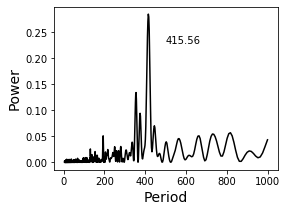

In [418]:
bpall = o.periodogram(iband,maxp=1000)

In [419]:
bp1

<Quantity 438.58573177>

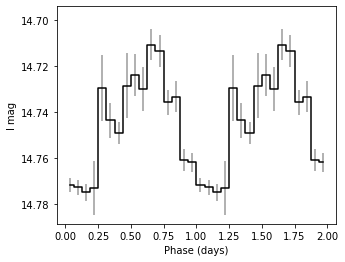

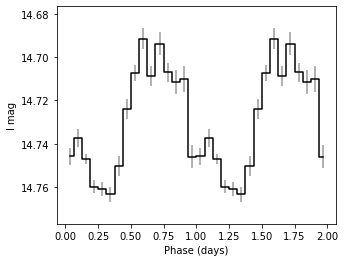

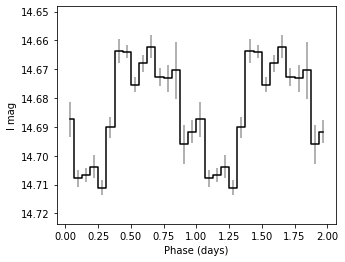

In [433]:
#use overall best on all three
plt.figure(figsize=(5,4))
o.phasestep(ilist[0],bpall,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=70,sterr=True,divide=True,label='')
plt.figure(figsize=(5,4))
o.phasestep(ilist[1],bpall,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=70,sterr=True,divide=True,label='')
plt.figure(figsize=(5,4))
o.phasestep(ilist[2],bpall,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=70,sterr=True,divide=True,label='')

no phase shift so not great evidence of change

In [428]:
bpall

<Quantity 415.56257149>

In [429]:
row = summ[summ['src_n']==72]
row['best period'] = bpall
summ[summ['src_n']==72] = row

In [431]:
summ[summ['src_n']==72]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,V-I transition,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part,I IQR
65,72,12.142035,-73.04181,0.0,0.69,414.91345,0.588423,NaN,14.713841,0.055775,...,NaN,NaN,NaN,-0.296249,-0.179276,-0.390153,0.398842,416.534718,2.0,0.081


# look for difference in orbital during big dips
- relationship between orbital and super-orbital
- probably move to another notebook

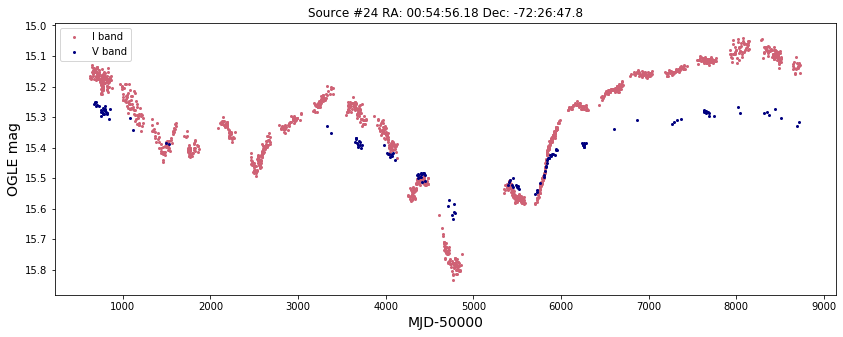

In [439]:
ilist,vlist = o.getIV(24,cross,stack=False,plot=True,figsize=(14,5))
# for i in range(-2,4):
#     plt.axvline(7550+400*i)
# for i in range(-1,5):
#     plt.axvline(2250+650*i,color='darkseagreen')


In [436]:
#best period
summ[summ['src_n']==24]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,V-I transition,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part,I IQR
22,24,13.734498,-72.44646,59.07,0.59,62.1,1.090329,NaN,15.332253,0.177328,...,NaN,NaN,NaN,0.549316,-0.272309,0.336276,-0.858391,60.913413,1.0,0.275


In [450]:
iband = vstack(ilist)
o.splinedetrend(iband,window=100)

<Quantity 15.33349287>

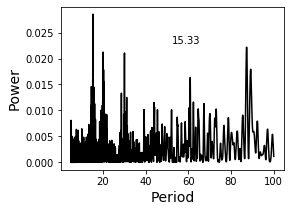

In [451]:
o.periodogram(iband,maxp=100,det=True)

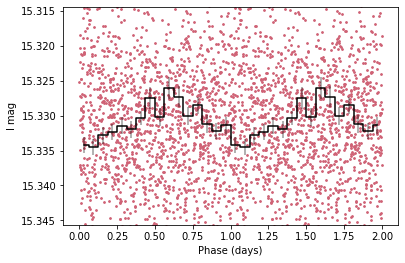

In [453]:
o.phasestep(iband,15.33,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=70,sterr=True,divide=True,label='')
plt.scatter((iband['MJD-50000']%15.33)/15.33,iband['I detrend'],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000']%15.33)/15.33,iband['I detrend'],s=3,color=pink)

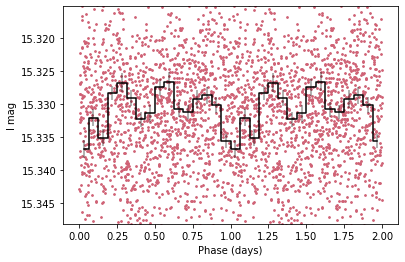

In [455]:
o.phasestep(iband,60.91,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=40,sterr=True,divide=True,label='')
plt.scatter((iband['MJD-50000']%60.9)/60.91,iband['I detrend'],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000']%60.9)/60.91,iband['I detrend'],s=3,color=pink)

(15.9, 15.1)

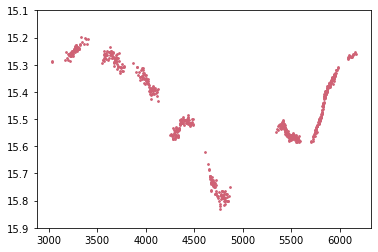

In [459]:
#find indices of dip
plt.scatter(iband['MJD-50000'][500:1200],iband['I mag'][500:1200],color=pink,s=3)
plt.ylim(15.9,15.1)

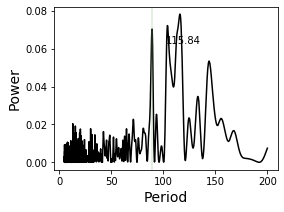

In [470]:
o.periodogram(iband[500:1200],det=True,maxp=200)
plt.axvline(89.2,color='darkseagreen',alpha=0.3)

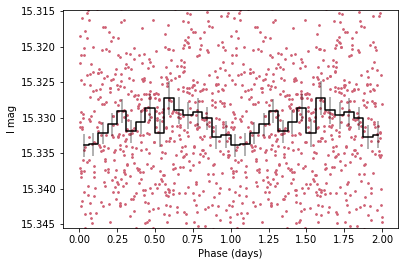

In [487]:
#15.33 during dip
o.phasestep(iband[500:1200],15.33,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=70,sterr=True,divide=True,label='')
plt.scatter((iband['MJD-50000'][500:1200]%15.33)/15.33,iband['I detrend'][500:1200],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000'][500:1200]%15.33)/15.33,iband['I detrend'][500:1200],s=3,color=pink)

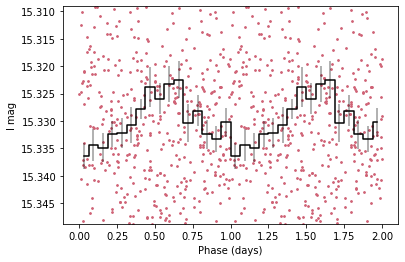

In [488]:
#before dip
o.phasestep(iband[:500],15.33,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=70,sterr=True,divide=True,label='')
plt.scatter((iband['MJD-50000'][:500]%15.33)/15.33,iband['I detrend'][:500],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000'][:500]%15.33)/15.33,iband['I detrend'][:500],s=3,color=pink)

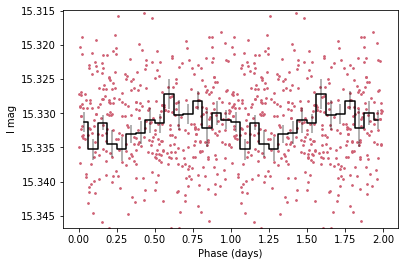

In [489]:
#after dip -- peaks a bit after 0.5 now?
o.phasestep(iband[1200:],15.33,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=70,sterr=True,divide=True,label='')
plt.scatter((iband['MJD-50000'][1200:]%15.33)/15.33,iband['I detrend'][1200:],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000'][1200:]%15.33)/15.33,iband['I detrend'][1200:],s=3,color=pink)

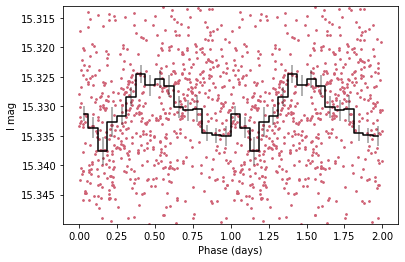

In [476]:
#just dip
pd = 89.2
o.phasestep(iband[500:1200],pd,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=-25,sterr=True,divide=True,label='')
plt.scatter((iband[500:1200]['MJD-50000']%pd)/pd,iband[500:1200]['I detrend'],s=3,color=pink)
plt.scatter(1+(iband[500:1200]['MJD-50000']%pd)/pd,iband[500:1200]['I detrend'],s=3,color=pink)

89.2 not effective before or after dip

found 115.84 period looks good before and during big dip, but not at all after
- and phase shift between those two

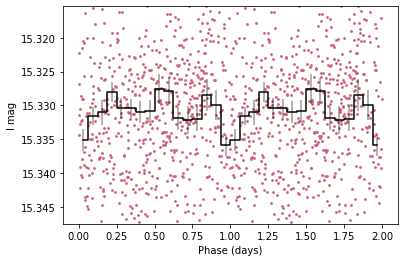

In [483]:
# during dip
o.phasestep(iband[500:1200],60.91,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=40,sterr=True,divide=True,label='')
plt.scatter((iband['MJD-50000'][500:1200]%60.9)/60.91,iband['I detrend'][500:1200],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000'][500:1200]%60.9)/60.91,iband['I detrend'][500:1200],s=3,color=pink)

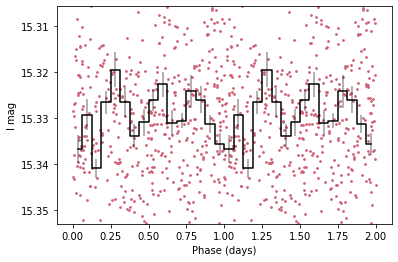

In [484]:
#before
o.phasestep(iband[:500],60.91,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=40,sterr=True,divide=True,label='')
plt.scatter((iband['MJD-50000'][:500]%60.9)/60.91,iband['I detrend'][:500],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000'][:500]%60.9)/60.91,iband['I detrend'][:500],s=3,color=pink)

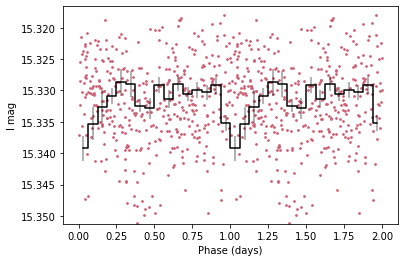

In [485]:
#after
#before
o.phasestep(iband[1200:],60.91,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=40,sterr=True,divide=True,label='')
plt.scatter((iband['MJD-50000'][1200:]%60.9)/60.91,iband['I detrend'][1200:],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000'][1200:]%60.9)/60.91,iband['I detrend'][1200:],s=3,color=pink)

60.91 not a super strong signal, but phase-fold looks good before, during, and after big dip with no apparent phase change
- plot all on same 


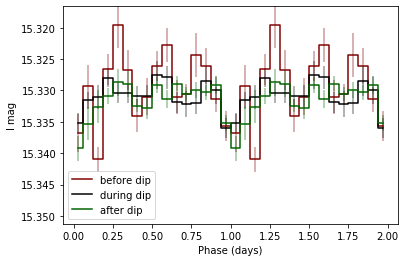

In [499]:
pd = 60.91
o.phasestep(iband[:500],pd,16,det=True,med=False,double=True,color='maroon',err=True,retall=False,epoch=40,sterr=True,divide=True,label='before dip')
o.phasestep(iband[500:1200],pd,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=40,sterr=True,divide=True,label='during dip')
o.phasestep(iband[1200:],pd,16,det=True,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=40,sterr=True,divide=True,label='after dip')
plt.legend()

- no difference during dip
- confirmed 60.91 better than est. period of 62

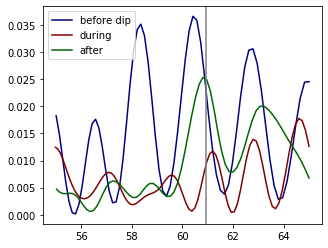

In [506]:
#zoomed in periodogram in each region
f1,p1,bp1 = o.periodogram(iband[:500],minp=55,maxp=65,more=True,plot=False,det=True)
f2,p2,bp2 = o.periodogram(iband[500:1200],minp=55,maxp=65,more=True,plot=False,det=True)
f3,p3,bp3 = o.periodogram(iband[1200:],minp=55,maxp=65,more=True,plot=False,det=True)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='before dip')
plt.plot(1/f2,p2,color='maroon',label='during')
plt.plot(1/f3,p3,color='darkgreen',label='after')
plt.legend()
plt.axvline(60.91,color='grey')

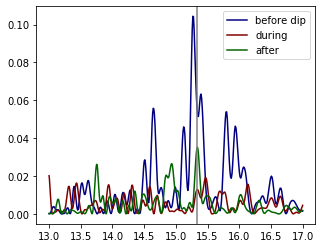

In [509]:
#zoomed in periodogram in each region
f1,p1,bp1 = o.periodogram(iband[:500],minp=13,maxp=17,more=True,plot=False,det=True)
f2,p2,bp2 = o.periodogram(iband[500:1200],minp=13,maxp=17,more=True,plot=False,det=True)
f3,p3,bp3 = o.periodogram(iband[1200:],minp=13,maxp=17,more=True,plot=False,det=True)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='before dip')
plt.plot(1/f2,p2,color='maroon',label='during')
plt.plot(1/f3,p3,color='darkgreen',label='after')
plt.legend()
plt.axvline(15.33,color='grey')

In [514]:
bp1

<Quantity 15.2679119>

15.33 more consistent? and narrower peak
- 15.27 doesn't work for others

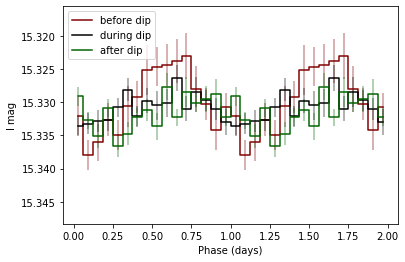

In [518]:
pd = 15.33
o.phasestep(iband[:500],pd,16,det=True,med=False,double=True,color='maroon',err=True,retall=False,epoch=40,sterr=True,divide=True,label='before dip')
o.phasestep(iband[500:1200],pd,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=40,sterr=True,divide=True,label='during dip')
o.phasestep(iband[1200:],pd,16,det=True,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=40,sterr=True,divide=True,label='after dip')
plt.legend()

## next big dip source: 23


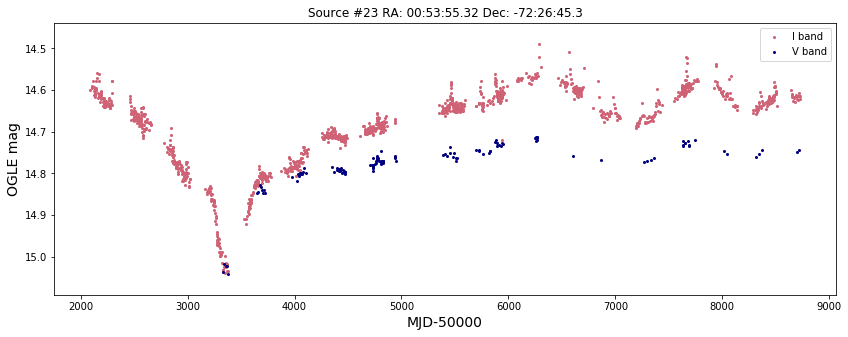

In [568]:
ilist,vlist = o.getIV(23,cross,stack=False,plot=True,figsize=(14,5))

amplitude increases with brightness? can't see the orbital peaks in dip
- investigate below

In [523]:
summ[summ['src_n']==23]

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,V-I transition,Type II amp,note,I skew,I kurtosis,V skew,V kurtosis,best auto det pd,Part,I IQR
21,23,13.480083,-72.44603,46.63,0.6,137.36,0.647529,NaN,14.68619,0.093824,...,NaN,NaN,NaN,1.22555,1.4785,2.927194,10.50737,137.916601,1.0,0.104


In [569]:
iband = vstack(ilist)

(15.1, 14.4)

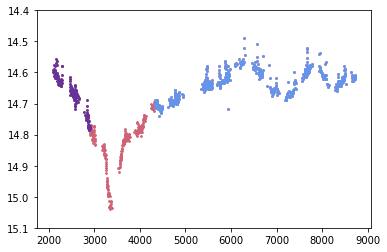

In [570]:
plt.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=3)
plt.scatter(iband['MJD-50000'][:200],iband['I mag'][:200],color=purple,s=3)
plt.scatter(iband['MJD-50000'][500:],iband['I mag'][500:],color=blue,s=3)

plt.ylim(15.1,14.4)

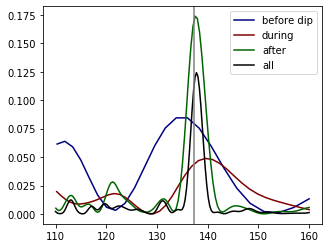

In [571]:
o.splinedetrend(iband,window=300)
#periodograms before, during, after dip
f1,p1,bp1 = o.periodogram(iband[:200],minp=110,maxp=160,more=True,plot=False,det=True)
f2,p2,bp2 = o.periodogram(iband[200:500],minp=110,maxp=160,more=True,plot=False,det=True)
f3,p3,bp3 = o.periodogram(iband[500:],minp=110,maxp=160,more=True,plot=False,det=True)
f4,p4,bp4 = o.periodogram(iband,minp=110,maxp=160,more=True,plot=False,det=True)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='before dip')
plt.plot(1/f2,p2,color='maroon',label='during')
plt.plot(1/f3,p3,color='darkgreen',label='after')
plt.plot(1/f4,p4,color='black',label='all')

plt.legend()
plt.axvline(137.36,color='grey')

In [574]:
bp4

<Quantity 137.76176613>

difference could just be from number of points so now look at phase-fold

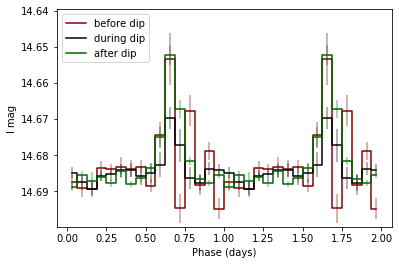

In [578]:
pd = bp4
o.phasestep(iband[:200],pd,16,det=True,med=False,double=True,color='maroon',err=True,retall=False,epoch=0,sterr=True,divide=True,label='before dip')
o.phasestep(iband[200:500],pd,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='during dip')
o.phasestep(iband[500:],pd,16,det=True,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=0,sterr=True,divide=True,label='after dip')
plt.legend()

**much lower amplitude during dip**
- could do more by digging into the flares during the dip


# 37

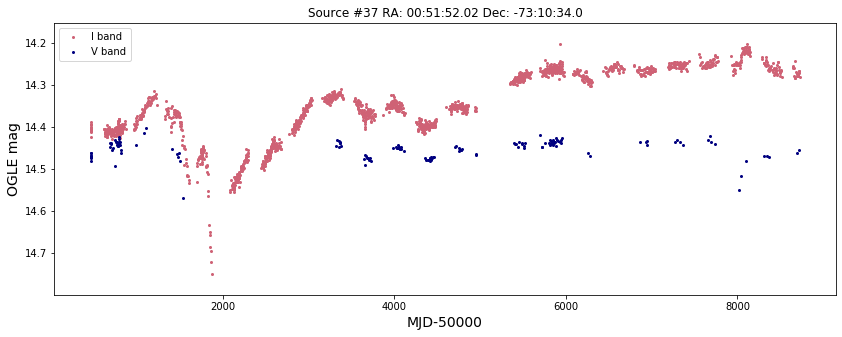

In [579]:
ilist,vlist = o.getIV(37,cross,stack=False,plot=True,figsize=(14,5))